In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.|

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from nltk.corpus import stopwords

# some linear models
from sklearn.linear_model import LogisticRegression, BayesianRidge

# SCM for classification
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
np.random.seed(2019)

In [3]:
# run once to download data
# import nltk
# nltk.download()

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_cat=pd.read_json('categories.json')

In [6]:
df_train['Group']=df_train.image_path.map(lambda x: x[:7])
df_test['Group']=df_test.image_path.map(lambda x: x[:7])

In [7]:
train,test=train_test_split(df_train,random_state=2019,stratify=df_train.Category,test_size=0.2)

In [8]:
# Let's check few examples
for i in range(10):
    print(train.title.iloc[i])

btb new blus casual wanita tanpa lengan dengan bahan sifon dan potongan longgar bergaya sexy
iphone 7 plus 128gb red fullset original
sale ben nye neutral set colorless powder poudre incolore 25 g
terlaris dermovate cream hijau original
termurah mini dress brokat gaun pesta murah party wanita
samasung s7 flat
obral 2018 new cotton checkered plaid blouses shirt cage female long sleeve casual slim women
marcks bedak tabur 20 g new cn86
new loreal paris true match blur cream 25ml stok terbatas
sweater kaos hoodie lengan panjang bahan velvet untuk pria wanita


## Building seperate models for each Groupb

In [9]:
ignore_words = set(stopwords.words('english')).union(set(stopwords.words('indonesian')))
print(len(ignore_words))

936


In [10]:
# let's check for all of the data. This slightly helps to reduce dimensionality
cv=CountVectorizer(stop_words=ignore_words)
cv1=CountVectorizer() # No, stop words
X_t=cv.fit_transform(train['title'])
X_t1=cv1.fit_transform(train['title'])
print('Some words are reduced by introducing stop words',X_t.shape[1],X_t1.shape[1])

Some words are reduced by introducing stop words 70586 70968


In [11]:
# let's build pipeline for parameter search in n_grams and and various models
lr=LogisticRegression()
nb=MultinomialNB()
svc=SVC()
# let's check first three and see which one is best
gnb=GaussianNB()
bnb=BernoulliNB()
br=BayesianRidge()

pipe_lr=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words)),('model',lr)])


In [12]:
%time pipe_lr.fit(train[train.Group=='beauty_'].title,train[train.Group=='beauty_'].Category)

Wall time: 1min 20s


Pipeline(memory=None,
     steps=[('vectorize', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'jang...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [13]:
%%time
test.head()

Wall time: 0 ns


,itemid,title,Category,image_path,Group
539829,1058517290,xiaomi mi a1 garansi resmi 1 tahun tam,34,mobile_image/3912586cdf51144db783b2bac1ee4d3f.jpg,mobile_
473036,286463264,blus sexy model off shoulder,26,fashion_image/cb790137111e2525cd895c3375fe84c0,fashion
252009,1537965166,best sale jafra royal jelly radiance foundatio...,1,beauty_image/5adfe3e65ad2f51a1e67db85a3de8e18.jpg,beauty_
355772,1465709373,dress midi bodycon casual elegan warna polos u...,22,fashion_image/cbedaa2404fb377dc6c271a1081f7baa,fashion
553954,1195506745,promo discon samsung galaxy s7 flat sein garan...,35,mobile_image/bb327fec3989b18f714deb3c07203fb8.jpg,mobile_


In [14]:
%%time
pred=pipe_lr.predict(test[test.Group=='beauty_'].title)

Wall time: 416 ms


In [15]:
%%time
accuracy_score(test[test.Group=='beauty_'].Category,pred)


# without removing stop words :0.76361288971858265
# removing stop_words: 0.7626009735331577

Wall time: 32.9 ms


0.7626009735331577

In [16]:
%%time
score=pipe_lr.score(test[test.Group=='beauty_'].title,test[test.Group=='beauty_'].Category)

Wall time: 446 ms


In [17]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

## Previously I have tried both TfidfVectorizer, CountVectorizer for both naive bayes and logistic regression. But it turns out that Countvectorizer with logistic regression gives best results. I have removed stop words from english and indonesian. Than, I did parameter optimization for n_grams. It turns out that best ngram_range is (1,3 for beauty and mobile products and (1,5) for fashion. 

## (1,5) might be not the most optimal we might still imporove by increasing it.


## I also run this simulation for NB. The optimal ngram_range was ... I lost it in kernel!!

## but it was smth like for mobile (1,2) and for beauty and fashion (2,5) we can do it again, it won't take much time. Score were still less than logistic regression

## I also tried svc (SVM) but it takes to much time imposimble to train espacially if there is many features



In [41]:
# Uncomment if u want to run this code but it will take a lot of time
# testing n jobs
# pipe_lr=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words)),('model',lr)])
# params={'vectorize__ngram_range':[(j,i) for j in range(1,3) for i in range(j,6)]}
# best_param={}
# best_score={}
# for group in tqdm(['beauty_','mobile_','fashion']):
#     grid_search=GridSearchCV(pipe_lr,param_grid=params, verbose=1)
#     X=df_train[df_train.Group==group].title
#     y=df_train[df_train.Group==group].Category
#     grid_search.fit(X,y)
#     best_param[group]=grid_search.best_params_
#     best_score[group]=grid_search.best_score_






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 70.8min finished





 33%|██████████████████████████                                                    | 1/3 [1:16:24<2:32:49, 4584.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 35.8min finished





 67%|████████████████████████████████████████████████████                          | 2/3 [1:54:44<1:04:59, 3899.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 79.9min finished





100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [3:25:23<00:00, 4361.02s/it]

In [43]:
best_param
# {'beauty_': {'vectorize__ngram_range': (1, 3)},
#  'mobile_': {'vectorize__ngram_range': (1, 3)},
#  'fashion': {'vectorize__ngram_range': (1, 5)}}

{'beauty_': {'vectorize__ngram_range': (1, 3)},
 'mobile_': {'vectorize__ngram_range': (1, 3)},
 'fashion': {'vectorize__ngram_range': (1, 5)}}

In [44]:
best_score
#{'beauty_': 0.78295293161143542,
#  'mobile_': 0.8236574564959771,
#  'fashion': 0.6426796296802032}

{'beauty_': 0.78295293161143542,
 'mobile_': 0.8236574564959771,
 'fashion': 0.6426796296802032}

In [47]:
# Best cv scores for parameter for lr.
pipe_beauty=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,ngram_range=(1,3))),('model',lr)])
pipe_mobile=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,ngram_range=(1,3))),('model',lr)])
pipe_fashion=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,ngram_range=(1,5))),('model',lr)])
pipe=[pipe_beauty,pipe_mobile,pipe_fashion]

In [48]:
groups=['beauty_','mobile_','fashion']
predictions={}
for i in range(3):
    model=pipe[i]
    X=df_train[df_train.Group==groups[i]].title
    y=df_train[df_train.Group==groups[i]].Category
    model.fit(X,y)
    predictions[groups[i]]=model.predict(df_test[df_test.Group==groups[i]].title)
    


In [49]:
# Let's also do it for 80 percent of data. As we did for images
predictions_val={}
predictions_test={}
for i in range(3):
    model=pipe[i]
    X=train[train.Group==groups[i]].title
    y=train[train.Group==groups[i]].Category
    model.fit(X,y)
    predictions_val[groups[i]]=model.predict(test[test.Group==groups[i]].title)
    predictions_test[groups[i]]=model.predict(df_test[df_test.Group==groups[i]].title)


In [82]:
def submission(name,dic):
    df_sub=df_test.copy()
    for group in dic.keys():
        df_sub.loc[df_sub.Group==group,'Category']=dic[group]
    df_sub.loc[:,'Category']=df_sub.Category.astype('int')
    df_sub[['itemid','Category']].to_csv(name,index=False)

In [83]:
# Let's check accuracy in validation set
for group in predictions_val.keys():
    test_=test.copy()
    test_.loc[test_.Group==group,'Category']=predictions_val[group]
print(accuracy_score(test.Category,test_.Category))
# Wow results seems to be impressive 0.884536051544

0.884536051544


In [84]:
# LB: 0.75599
# Trained to 80% of data
submission('first_nlp_submission.csv',predictions_test)

In [87]:
# Trained to all data: 0.76140
# Trained to all data. Improved to 0.0054

submission('2_nlp_all_data.csv',predictions)

In [98]:
# We need to save predict proba for both validation and test set. also save for predict proba for 

predict_proba_val={}
predict_proba_test={}
classes={}
for i in range(3):
    model=pipe[i]
    X=train[train.Group==groups[i]].title
    y=train[train.Group==groups[i]].Category
    model.fit(X,y)
    classes[groups[i]]=model.classes_
    predictions_val[groups[i]]=model.predict_proba(test[test.Group==groups[i]].title)
    predictions_test[groups[i]]=model.predict_proba(df_test[df_test.Group==groups[i]].title)

In [135]:
# Saving probabilities of validation set
for i in range(3):
    df=pd.DataFrame(predictions_val[groups[i]])
    df.columns=classes[groups[i]]
    df['pred']=df.idxmax(axis=1) # do it before placing itemid or category otherwise column type will become string type
    df['itemid']=test[test.Group==groups[i]].itemid.values # values is essensial since indexes are different
    df['Category']=test[test.Group==groups[i]].Category.values
    df.to_csv(groups[i]+'_val_proba_nlp.csv',index=False)
    

In [232]:
for i in range(3):
    df=pd.DataFrame(predictions_test[groups[i]])
    df.columns=classes[groups[i]]
    df['pred']=df.idxmax(axis=1)
    df['itemid']=df_test[df_test.Group==groups[i]].itemid.values
    df.to_csv(groups[i]+'_test_proba_nlp.csv',index=False)

In [146]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib notebook
from sklearn.metrics import confusion_matrix

In [189]:
groups

['beauty_', 'mobile_', 'fashion']

In [190]:
# Similar names for columns as groups
df_cat.columns=['beauty_','fashion','mobile_']

In [191]:
def plot_confusion(group):
    df_val=pd.read_csv(group+'_val_proba_nlp.csv')
    confusion=confusion_matrix(df_val['Category'],df_val['pred'])
    labels=df_cat[group].dropna().astype('int').sort_values().index
    sns.heatmap(confusion,annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5,xticklabels=labels,yticklabels=labels)


<IPython.core.display.Javascript object>


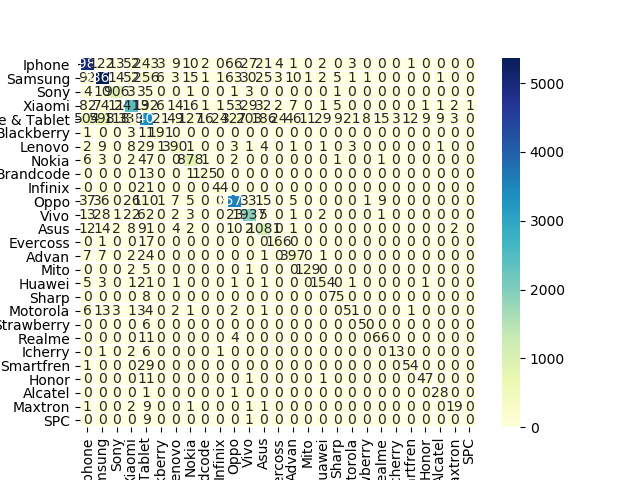

In [195]:
# 
plot_confusion('mobile_')

## Let's predict with naive bayes approach

In [202]:
# Uncomment if u want to run this code but it will take a lot of time

pipe_nb=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words)),('model',nb)])
params={'vectorize__ngram_range':[(j,i) for j in range(1,4) for i in range(j,7)]}
best_param_nb={}
best_score_nb={}
for group in tqdm(['beauty_','mobile_','fashion']):
    grid_search=GridSearchCV(pipe_nb,param_grid=params, verbose=1)
    X=df_train[df_train.Group==group].title
    y=df_train[df_train.Group==group].Category
    grid_search.fit(X,y)
    best_param_nb[group]=grid_search.best_params_
    print(group+ ' best parameters :',grid_search.best_params_ )
    best_score_nb[group]=grid_search.best_score_
    print(group+ ' best score :',grid_search.best_score_)







  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  7.3min finished


beauty_ best parameters : {'vectorize__ngram_range': (2, 6)}
beauty_ best score : 0.759556568254








 33%|███████████████████████████▋                                                       | 1/3 [07:28<14:56, 448.42s/it]

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.9min finished


mobile_ best parameters : {'vectorize__ngram_range': (1, 2)}
mobile_ best score : 0.776423626271








 67%|███████████████████████████████████████████████████████▎                           | 2/3 [12:25<06:43, 403.06s/it]

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  8.8min finished


fashion best parameters : {'vectorize__ngram_range': (2, 6)}
fashion best score : 0.585465767267








100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [21:31<00:00, 445.87s/it]

In [203]:
print(best_param_nb)
print(best_score_nb)
# {'beauty_': {'vectorize__ngram_range': (2, 6)}, 'mobile_': {'vectorize__ngram_range': (1, 2)}, 'fashion': {'vectorize__ngram_range': (2, 6)}}
# {'beauty_': 0.75955656825422302, 'mobile_': 0.7764236262708164, 'fashion': 0.58546576726657018}

{'beauty_': {'vectorize__ngram_range': (2, 6)}, 'mobile_': {'vectorize__ngram_range': (1, 2)}, 'fashion': {'vectorize__ngram_range': (2, 6)}}
{'beauty_': 0.75955656825422302, 'mobile_': 0.7764236262708164, 'fashion': 0.58546576726657018}


In [204]:
pipe_nb_beauty=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,ngram_range=(2,6))),('model',nb)])
pipe_nb_mobile=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,ngram_range=(1,2))),('model',nb)])
pipe_nb_fashion=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,ngram_range=(2,6))),('model',nb)])

pipe_nb_all=[pipe_nb_beauty,pipe_nb_mobile,pipe_nb_fashion]


In [219]:
groups

['beauty_', 'mobile_', 'fashion']

In [205]:
# Let's get predictions and predict proba for naive bayes approch
pred_nb_proba_val={}
pred_nb_proba_test={}
classes={}
for i in range(3):
    model=pipe_nb_all[i]
    X=train[train.Group==groups[i]].title
    y=train[train.Group==groups[i]].Category
    model.fit(X,y)
    classes[groups[i]]=model.classes_
    pred_nb_proba_val[groups[i]]=model.predict_proba(test[test.Group==groups[i]].title)
    pred_nb_proba_test[groups[i]]=model.predict_proba(df_test[df_test.Group==groups[i]].title)

In [206]:
# Saving probabilities of validation set
for i in range(3):
    df=pd.DataFrame(pred_nb_proba_val[groups[i]])
    df.columns=classes[groups[i]]
    df['pred']=df.idxmax(axis=1) # do it before placing itemid or category otherwise column type will become string type
    df['itemid']=test[test.Group==groups[i]].itemid.values # values is essensial since indexes are different
    df['Category']=test[test.Group==groups[i]].Category.values
    df.to_csv(groups[i]+'_val_proba_nlp_nb.csv',index=False)
    

In [230]:
# Saving Predictions for final test set
for i in range(3):
    df=pd.DataFrame(pred_nb_proba_test[groups[i]])
    df.columns=classes[groups[i]]
    df['pred']=df.idxmax(axis=1)
    df['itemid']=df_test[df_test.Group==groups[i]].itemid.values
    df.to_csv(groups[i]+'_test_proba_nlp_nb.csv',index=False)

In [234]:
## Now let's try ensembling
## Predict proba values are extreme it will be hard to use them for ensembling
df=pd.read_csv('fashion_test_proba_nlp_nb.csv')
df.head()

,17,18,19,20,21,22,23,24,25,26,27,28,29,30,pred,itemid
0,6.720209e-43,1.000000,6.149509e-34,3.309461e-25,2.752949e-26,1.695179e-24,2.027707e-44,6.182425e-40,1.329289e-25,6.679208e-24,5.952756e-33,4.125224e-38,8.234526e-40,1.453271e-44,18,670968580
1,4.075469e-37,1.000000,1.932446e-25,6.487402e-09,1.458588e-14,1.090629e-14,4.815468e-40,3.591847e-25,2.738468e-16,2.619602e-14,4.532866e-17,1.365040e-26,2.068206e-31,1.270402e-35,18,475599610
2,4.146882e-23,1.000000,2.141677e-14,9.282700e-11,3.845574e-07,3.441676e-08,1.585585e-23,1.909405e-14,3.356453e-09,1.760287e-11,4.032022e-12,7.451022e-16,3.550435e-17,5.839274e-21,18,1652671018
3,2.718293e-54,1.000000,9.744483e-29,1.426167e-11,1.814553e-16,3.252939e-13,1.022717e-42,2.185748e-34,7.387602e-20,1.746652e-20,1.046630e-25,3.519806e-25,2.050690e-34,6.939551e-52,18,1705634904
4,3.974198e-13,0.996962,5.236210e-08,2.294817e-06,1.710155e-07,1.289462e-04,4.849529e-13,2.216650e-10,1.897201e-05,2.887897e-03,2.958207e-09,2.041948e-13,3.297127e-13,1.762035e-13,18,1789421087


In [245]:
df_image_beauty=pd.read_csv('val_beauty.csv')
df_nlp=pd.read_csv('beauty__val_proba_nlp.csv')

In [263]:
# Accuracy of image prediction
accuracy_score(df_image_beauty.Category,df_image_beauty.final_pred)

0.6406476263586719

In [265]:
#nlp accuracy
accuracy_score(df_nlp.Category,df_nlp.pred)

0.78843972992305944

In [254]:
df_image_beauty.loc[:,[str(i) for i in range(17)]].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000922,0.063919,0.075449,0.579613,0.063179,0.118592,0.000373,0.002519,0.002103,0.009568,0.000129,0.002412,0.036417,0.015067,0.011914,0.000337,0.017487
1,0.016552,0.028079,0.275765,0.210556,0.026311,0.011866,0.011437,0.027535,0.285640,0.007712,0.000746,0.091571,0.003485,0.000700,0.000629,0.000639,0.000780
2,0.001821,0.001831,0.001431,0.007295,0.022690,0.001862,0.000222,0.004479,0.000819,0.003514,0.000504,0.000466,0.764857,0.050797,0.099181,0.008131,0.030099
3,0.019760,0.051505,0.006417,0.043640,0.609103,0.086127,0.002845,0.019252,0.018621,0.044650,0.002228,0.005470,0.037858,0.023969,0.008131,0.001418,0.019008
4,0.171279,0.184560,0.060845,0.159701,0.058774,0.020588,0.052695,0.024520,0.146287,0.017349,0.000596,0.099867,0.001841,0.000397,0.000278,0.000162,0.000261


In [270]:
X1=df_image_beauty.loc[:,[str(i) for i in range(17)]].copy()
X1.columns=[i for i in range(17)]

In [266]:
df_nlp.iloc[:,0:17].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000027,0.896262,0.000033,0.000010,0.001904,0.100763,0.000003,0.000463,0.000023,0.000169,0.000036,0.000199,0.000021,0.000003,0.000013,0.000013,0.000058
1,0.000825,0.005611,0.003361,0.961518,0.010616,0.001984,0.000567,0.006267,0.002280,0.003172,0.000170,0.000419,0.002085,0.000285,0.000516,0.000143,0.000179
2,0.001282,0.091998,0.272629,0.490585,0.015732,0.111034,0.001554,0.005411,0.002612,0.001932,0.000262,0.000681,0.002210,0.000432,0.001130,0.000267,0.000249
3,0.000192,0.026769,0.000271,0.018368,0.001578,0.930594,0.000010,0.001087,0.000201,0.011185,0.000008,0.008811,0.000718,0.000030,0.000019,0.000007,0.000151
4,0.000273,0.053303,0.000145,0.001818,0.009964,0.014201,0.001225,0.000228,0.000170,0.917750,0.000064,0.000088,0.000141,0.000127,0.000161,0.000067,0.000278


In [271]:
X2=df_nlp.iloc[:,0:17].copy()

In [300]:
score=[]
for i in range(101):
    X3=(i/100)*X2.values+(1-i/100)*X1.values
    df=pd.DataFrame(X3)
    score.append(accuracy_score(df.idxmax(axis=1),df_nlp.Category))
    
        

In [302]:
# extremely small improvement
score.index(max(score))

99

In [304]:
df_image=pd.read_csv('val_fashion.csv')
df_nlp=pd.read_csv('fashion_val_proba_nlp.csv')

In [307]:
accuracy_score(df_image.Category,df_image.final_pred)

0.49061241209804057

In [309]:
accuracy_score(df_nlp.Category,df_nlp.pred)

0.6496665983933001

In [335]:
for i in range(1,20):
    cv=CountVectorizer(stop_words=ignore_words,min_df=i)
    X=df_train[df_train.Group=='mobile_'].title
    cv.fit(X)
    print('Number of features in min_df='+str(i)+' is '+str(len(cv.get_feature_names())))

Number of features in min_df=1 is 24240
Number of features in min_df=2 is 13440
Number of features in min_df=3 is 10085
Number of features in min_df=4 is 8338
Number of features in min_df=5 is 7201
Number of features in min_df=6 is 6403
Number of features in min_df=7 is 5796
Number of features in min_df=8 is 5330
Number of features in min_df=9 is 4906
Number of features in min_df=10 is 4583
Number of features in min_df=11 is 4308
Number of features in min_df=12 is 4078
Number of features in min_df=13 is 3862
Number of features in min_df=14 is 3681
Number of features in min_df=15 is 3526
Number of features in min_df=16 is 3377
Number of features in min_df=17 is 3237
Number of features in min_df=18 is 3120
Number of features in min_df=19 is 3017


In [351]:
# Let's try to remove tune min_df
for grou

Pipeline(memory=None,
     steps=[('vectorize', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'jang...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [349]:
len(cv.get_feature_names())

7926

In [352]:
groups

['beauty_', 'mobile_', 'fashion']

In [353]:
# very minor improvement but it might be helpful to use for other groups 
# let's run it with best parameters
pipe_beauty=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,ngram_range=(1,3))),('model',lr)])
pipe_mobile=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,ngram_range=(1,3))),('model',lr)])
pipe_fashion=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,ngram_range=(1,5))),('model',lr)])
pipes=[pipe_beauty,pipe_mobile,pipe_fashion]

params={'vectorize__min_df':[1,2,3,4,5]}
best_param_min_df={}
best_score_min_df={}
for i in tqdm(range(len(groups))):
    grid_search=GridSearchCV(pipes[i],param_grid=params, verbose=1)
    X=df_train[df_train.Group==groups[i]].title
    y=df_train[df_train.Group==groups[i]].Category
    grid_search.fit(X,y)
    best_param_min_df[group]=grid_search.best_params_
    print(groups[i]+ ' best parameters :',grid_search.best_params_ )
    best_score_min_df[group]=grid_search.best_score_
    print(groups[i]+ ' best score :',grid_search.best_score_)
# There is almost no improvement... Online very minor for mobile min_df=2








  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 37.0min finished


beauty_ best parameters : {'vectorize__min_df': 2}
beauty_ best score : 0.783089017841









 33%|██████████████████████████▋                                                     | 1/3 [41:39<1:23:19, 2499.68s/it]

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 18.5min finished


mobile_ best parameters : {'vectorize__min_df': 1}
mobile_ best score : 0.823657456496









 67%|█████████████████████████████████████████████████████▎                          | 2/3 [1:02:43<35:28, 2128.93s/it]

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 58.9min finished


fashion best parameters : {'vectorize__min_df': 1}
fashion best score : 0.64267962968









100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [2:12:27<00:00, 2745.37s/it]

In [354]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

In [481]:
df_image_beauty.reset_index(inplace=True)

In [483]:
del df_image_beauty['index']

In [485]:
del df_image_beauty['Category']

In [486]:
df_image_beauty

,image_path2,0,1,10,11,12,13,14,15,16,2,3,4,5,6,7,8,9,final_pred
0,0057fd944e705684de3b169f1fd7b20e.jpg,0.000922,0.063919,0.000129,0.002412,0.036417,0.015067,0.011914,3.367541e-04,0.017487,0.075449,0.579613,0.063179,0.118592,0.000373,0.002519,0.002103,0.009568,3
1,0093bb60e9adb6b2d842d87d4a8d6130.jpg,0.016552,0.028079,0.000746,0.091571,0.003485,0.000700,0.000629,6.389772e-04,0.000780,0.275765,0.210556,0.026311,0.011866,0.011437,0.027535,0.285640,0.007712,8
2,00e358a25a00c6edabbff0f7c4fa424e.jpg,0.001821,0.001831,0.000504,0.000466,0.764857,0.050797,0.099181,8.130950e-03,0.030099,0.001431,0.007295,0.022690,0.001862,0.000222,0.004479,0.000819,0.003514,12
3,0123b0a5ebbd601a14357274ebcdde46.jpg,0.019760,0.051505,0.002228,0.005470,0.037858,0.023969,0.008131,1.417745e-03,0.019008,0.006417,0.043640,0.609103,0.086127,0.002845,0.019252,0.018621,0.044650,4
4,01ec05eb7e3f009b254ccc116d21ed3c.jpg,0.171279,0.184560,0.000596,0.099867,0.001841,0.000397,0.000278,1.624354e-04,0.000261,0.060845,0.159701,0.058774,0.020588,0.052695,0.024520,0.146287,0.017349,1
5,0284bf8a937d842babf08f0543945820.jpg,0.223052,0.053775,0.001460,0.017564,0.149742,0.019295,0.016455,4.448426e-03,0.010835,0.192682,0.055030,0.101843,0.039617,0.007031,0.063584,0.023463,0.020123,0
6,0312eef79600cff9db83c7548bdee626.jpg,0.006035,0.038235,0.000077,0.000115,0.001218,0.000324,0.000490,3.354100e-05,0.000809,0.000279,0.051783,0.710489,0.145800,0.000079,0.028268,0.000100,0.015866,4
7,03239f2f459bdaa6b6f994c1cec80246.jpg,0.020024,0.085691,0.003408,0.008025,0.024663,0.001883,0.002203,5.405118e-04,0.004966,0.014263,0.024489,0.394828,0.111328,0.005763,0.186958,0.010578,0.100390,4
8,0368988b36278a5256c54e67ae011cb6.jpg,0.114477,0.290376,0.000375,0.075370,0.006455,0.001330,0.000638,3.766234e-04,0.001017,0.025773,0.074805,0.161356,0.084511,0.031352,0.024979,0.072711,0.034099,1
9,042b27ae3869106705f1f9dd096c8048.jpg,0.323987,0.078905,0.000048,0.015746,0.019355,0.000757,0.001535,1.049441e-04,0.000754,0.213904,0.031356,0.059145,0.001402,0.006350,0.180981,0.021099,0.044571,0


In [487]:
del test_beauty['image_pred']

In [497]:
df_all=test_beauty.merge(df_image_beauty,on='image_path2',how='outer')

In [500]:
df_im=df_all[[str(i) for i in range(17)]]

In [505]:
# Let's try to ensemble results of nlp and image categorization using svm or lr
# the main idea is to use each probability as feature to svm or lr

df_im.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.002413,0.644621,0.000998,0.082524,0.185229,0.039663,0.000129,0.005326,0.000772,0.033910,0.001621,0.000406,0.000633,0.000953,0.000371,0.000054,0.000377
1,0.004281,0.045959,0.013224,0.722170,0.023957,0.147752,0.002059,0.003475,0.006804,0.015817,0.000369,0.001236,0.010823,0.000401,0.000729,0.000254,0.000692
2,0.001220,0.056316,0.289336,0.124023,0.015513,0.488652,0.000476,0.002027,0.011963,0.007191,0.000071,0.002718,0.000313,0.000019,0.000111,0.000012,0.000040
3,0.004866,0.039073,0.000995,0.028858,0.313440,0.549227,0.000116,0.004704,0.000787,0.048756,0.000594,0.000344,0.005737,0.000891,0.000419,0.000092,0.001101
4,0.000828,0.009464,0.000383,0.001625,0.033192,0.036198,0.000008,0.001147,0.000120,0.915869,0.000020,0.000047,0.000512,0.000203,0.000226,0.000021,0.000138


In [507]:
df_nlp=df_beauty_val[[str(i) for i in range(17)]]

In [511]:
df_nlp.columns=['nlp_'+str(i) for i in range(17)]

In [531]:
df_im

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.002413,0.644621,0.000998,0.082524,0.185229,0.039663,0.000129,0.005326,0.000772,0.033910,0.001621,0.000406,0.000633,9.527985e-04,3.706687e-04,5.393895e-05,3.774205e-04
1,0.004281,0.045959,0.013224,0.722170,0.023957,0.147752,0.002059,0.003475,0.006804,0.015817,0.000369,0.001236,0.010823,4.013048e-04,7.291195e-04,2.541626e-04,6.918323e-04
2,0.001220,0.056316,0.289336,0.124023,0.015513,0.488652,0.000476,0.002027,0.011963,0.007191,0.000071,0.002718,0.000313,1.871935e-05,1.112803e-04,1.194500e-05,3.992775e-05
3,0.004866,0.039073,0.000995,0.028858,0.313440,0.549227,0.000116,0.004704,0.000787,0.048756,0.000594,0.000344,0.005737,8.907489e-04,4.185867e-04,9.232941e-05,1.101192e-03
4,0.000828,0.009464,0.000383,0.001625,0.033192,0.036198,0.000008,0.001147,0.000120,0.915869,0.000020,0.000047,0.000512,2.030630e-04,2.260823e-04,2.143952e-05,1.377837e-04
5,0.000052,0.978903,0.000081,0.003738,0.012171,0.003477,0.000002,0.000273,0.000010,0.000619,0.000002,0.000028,0.000137,1.171067e-04,2.987550e-04,1.890353e-06,9.004579e-05
6,0.001010,0.101947,0.009544,0.091389,0.139328,0.625158,0.000200,0.006195,0.001398,0.013843,0.000429,0.001028,0.005639,9.286660e-04,7.751081e-04,3.936795e-04,7.937095e-04
7,0.000720,0.098268,0.000339,0.696277,0.048213,0.130090,0.000660,0.008694,0.002932,0.011390,0.000057,0.002250,0.000043,1.777026e-05,1.727706e-05,5.532574e-06,2.594298e-05
8,0.017636,0.165177,0.015360,0.104900,0.288939,0.154400,0.034763,0.059892,0.043991,0.039029,0.001912,0.019954,0.037049,5.839184e-03,4.857896e-03,1.556486e-03,4.743981e-03
9,0.000489,0.003210,0.015484,0.948600,0.008395,0.004583,0.000008,0.001271,0.000227,0.002091,0.000033,0.000122,0.002098,8.667184e-03,3.042288e-03,2.931262e-05,1.649661e-03


In [514]:
df_all_prob=df_nlp.join(df_im)

In [519]:
y=df_beauty_val.Category

In [521]:
from sklearn.linear_model import LogisticRegressionCV

In [523]:
lr_cv=LogisticRegressionCV()
lr_cv.fit(df_all_prob,y)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [527]:
y_pred=lr_cv.predict(df_all_prob)


In [529]:
accuracy_score(y,y_pred)

0.78929462463143574

In [532]:
# Let's try to use logistic regression to all data
lr=LogisticRegression()
lr.fit(df_all_prob,y)
y_pred=lr.predict(df_all_prob)
accuracy_score(y,y_pred)

0.78964356124709945

In [537]:
from sklearn.neighbors import KNeighborsClassifier

In [535]:
svc=SVC()
svc.fit(df_all_prob,y)
y_pred=svc.predict(df_all_prob)
accuracy_score(y,y_pred)

0.78770696303016552

In [544]:
nb=MultinomialNB()
nb.fit(df_all_prob,y)
y_pred=nb.predict(df_all_prob)
accuracy_score(y,y_pred)

0.78044908142435931

In [545]:
# Might be overfitting requires cross validation. 
knn=KNeighborsClassifier()
knn.fit(df_all_prob,y)
y_pred=knn.predict(df_all_prob)
accuracy_score(y,y_pred)

0.81689551093043944

In [549]:
X_train_en,X_test_en,y_train_en,y_test_en=train_test_split(df_all_prob,y,stratify=y,random_state=2019,test_size=0.2)

In [556]:
scores=[]
for i in range(5,200,5):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_en,y_train_en)
    y_pred=knn.predict(X_test_en)
    scores.append(accuracy_score(y_test_en,y_pred))

In [562]:
# Wow, this is quite amazing! We might fit later for all of the data to get even better results
# Some parameter tunning might help

print('Best score: ', max(scores), '.Best number of neighbors for knn:', scores.index(max(scores))*5)

Best score:  0.795795533845 .Best number of neighbors for knn: 155


<IPython.core.display.Javascript object>


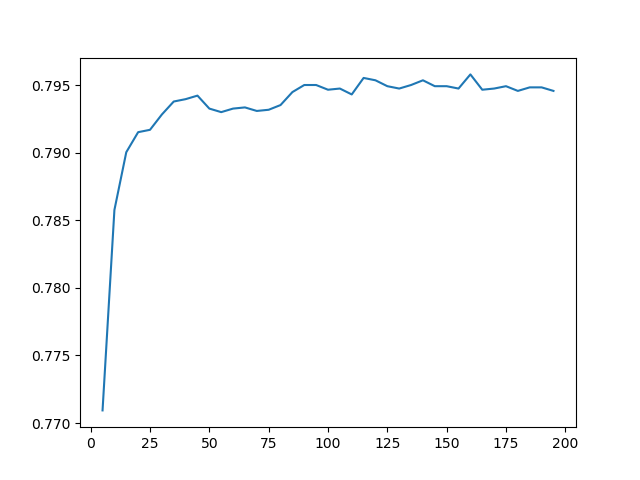

In [558]:
plt.figure()
plt.plot(range(5,200,5),scores)

In [565]:
# Let's try other algorithms such as random forrest or gradient boosting
scores_rf=[]
for i in range(10,200,10):
    rf=RandomForestClassifier(n_estimators=i)
    rf.fit(X_train_en,y_train_en)
    y_pred=rf.predict(X_test_en)
    scores_rf.append(accuracy_score(y_test_en,y_pred))


In [572]:
print('Best score for random forrest: ', max(scores_rf), '.Best number trees:', scores.index(max(scores_rf))*10)

Best score for random forrest:  0.795795533845 .Best number trees: 310


<IPython.core.display.Javascript object>


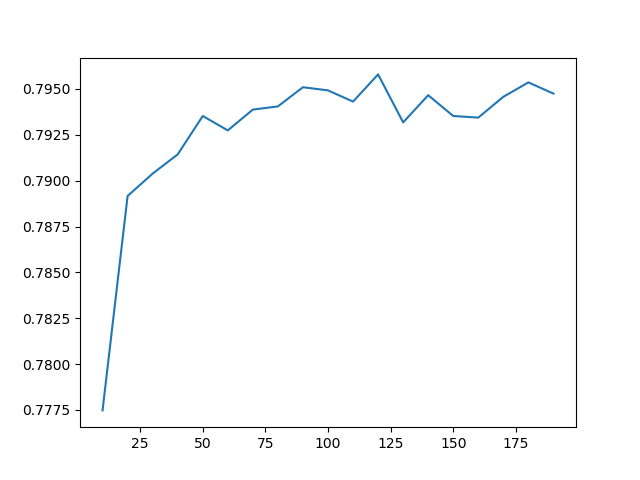

In [566]:
plt.figure()
plt.plot(range(10,200,10),scores_rf)

In [568]:
from sklearn.ensemble import GradientBoostingClassifier


In [569]:
scores_gb=[]
for i in range(10,200,10):
    gb=GradientBoostingClassifier(n_estimators=i)
    gb.fit(X_train_en,y_train_en)
    y_pred=gb.predict(X_test_en)
    scores_gb.append(accuracy_score(y_test_en,y_pred))


<IPython.core.display.Javascript object>


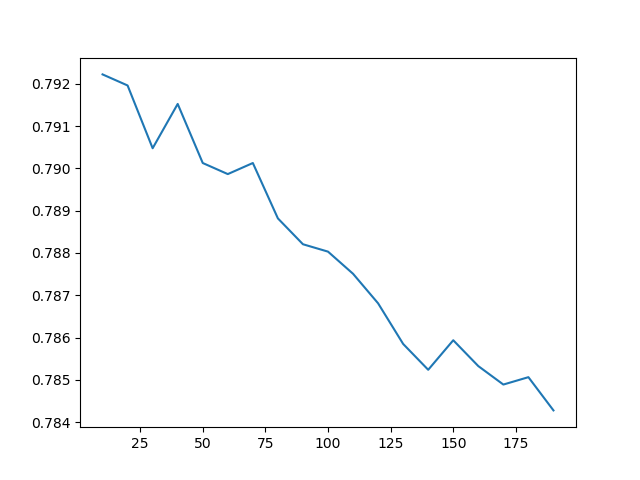

In [570]:
# it seems like overfitting
plt.figure()
plt.plot(range(10,200,10),scores_gb)

In [571]:
scores_gb_1=[]
for i in range(1,10):
    gb=GradientBoostingClassifier(n_estimators=i)
    gb.fit(X_train_en,y_train_en)
    y_pred=gb.predict(X_test_en)
    scores_gb_1.append(accuracy_score(y_test_en,y_pred))

<IPython.core.display.Javascript object>


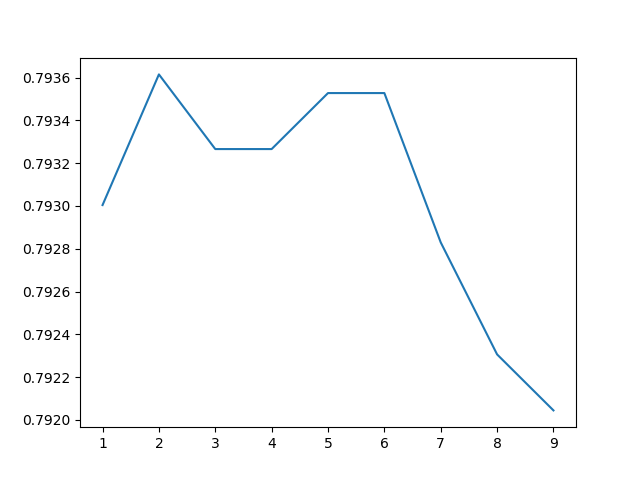

In [573]:
plt.figure()
plt.plot(range(1,10),scores_gb_1)

In [585]:
# Let's check our accuracy for given test score. Previous cv might not be good to compare since it is based on all validation data
# We can just use similar splitting and test results
Xtr,Xte=train_test_split(df_beauty_val,stratify=df_beauty_val.Category,random_state=2019,test_size=0.2)


In [586]:
# OMG it is quite good in this particular range. If we change random states rmse can go down to 0.784.
# We need to do proper cross validation . Using out of fold validation
accuracy_score(Xte.Category,Xte.pred)

0.79378925331472439

In [589]:
from sklearn.model_selection import StratifiedKFold

In [590]:
df_all_prob.head()

,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,...,7,8,9,10,11,12,13,14,15,16
0,0.000027,0.896262,0.000033,0.000010,0.001904,0.100763,0.000003,0.000463,0.000023,0.000169,...,0.005326,0.000772,0.033910,0.001621,0.000406,0.000633,0.000953,0.000371,0.000054,0.000377
1,0.000825,0.005611,0.003361,0.961518,0.010616,0.001984,0.000567,0.006267,0.002280,0.003172,...,0.003475,0.006804,0.015817,0.000369,0.001236,0.010823,0.000401,0.000729,0.000254,0.000692
2,0.001282,0.091998,0.272629,0.490585,0.015732,0.111034,0.001554,0.005411,0.002612,0.001932,...,0.002027,0.011963,0.007191,0.000071,0.002718,0.000313,0.000019,0.000111,0.000012,0.000040
3,0.000192,0.026769,0.000271,0.018368,0.001578,0.930594,0.000010,0.001087,0.000201,0.011185,...,0.004704,0.000787,0.048756,0.000594,0.000344,0.005737,0.000891,0.000419,0.000092,0.001101
4,0.000273,0.053303,0.000145,0.001818,0.009964,0.014201,0.001225,0.000228,0.000170,0.917750,...,0.001147,0.000120,0.915869,0.000020,0.000047,0.000512,0.000203,0.000226,0.000021,0.000138


In [593]:
def eval_model(model):
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_all_prob))
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_prob,y)):
        print("Fold:",fold_)
        X_train=df_all_prob.loc[trn_idx,:]
        y_train=y[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_prob.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
        print('Acuracy of fold:',accuracy_score(y[val_idx],oof[val_idx]))
    return accuracy_score(y,oof)


In [596]:
df_all_prob.head()

,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,...,7,8,9,10,11,12,13,14,15,16
0,0.000027,0.896262,0.000033,0.000010,0.001904,0.100763,0.000003,0.000463,0.000023,0.000169,...,0.005326,0.000772,0.033910,0.001621,0.000406,0.000633,0.000953,0.000371,0.000054,0.000377
1,0.000825,0.005611,0.003361,0.961518,0.010616,0.001984,0.000567,0.006267,0.002280,0.003172,...,0.003475,0.006804,0.015817,0.000369,0.001236,0.010823,0.000401,0.000729,0.000254,0.000692
2,0.001282,0.091998,0.272629,0.490585,0.015732,0.111034,0.001554,0.005411,0.002612,0.001932,...,0.002027,0.011963,0.007191,0.000071,0.002718,0.000313,0.000019,0.000111,0.000012,0.000040
3,0.000192,0.026769,0.000271,0.018368,0.001578,0.930594,0.000010,0.001087,0.000201,0.011185,...,0.004704,0.000787,0.048756,0.000594,0.000344,0.005737,0.000891,0.000419,0.000092,0.001101
4,0.000273,0.053303,0.000145,0.001818,0.009964,0.014201,0.001225,0.000228,0.000170,0.917750,...,0.001147,0.000120,0.915869,0.000020,0.000047,0.000512,0.000203,0.000226,0.000021,0.000138


In [597]:
accuracy_score(df_beauty_val.Category,df_beauty_val.pred)

0.78843972992305944

In [594]:
knn=KNeighborsClassifier(n_neighbors=150)
eval_model(knn)

Fold: 0
Acuracy of fold: 0.785963382738
Fold: 1
Acuracy of fold: 0.786742259049
Fold: 2
Acuracy of fold: 0.794643636046
Fold: 3
Acuracy of fold: 0.791746641075
Fold: 4
Acuracy of fold: 0.786156934625


0.7890503690004711

In [598]:
rf=RandomForestClassifier(n_estimators=120)
eval_model(rf)

Fold: 0
Acuracy of fold: 0.786922406277
Fold: 1
Acuracy of fold: 0.789097252508
Fold: 2
Acuracy of fold: 0.795603245224
Fold: 3
Acuracy of fold: 0.79052521375
Fold: 4
Acuracy of fold: 0.787117046347


0.78985292321649769

In [599]:
lr=LogisticRegression()
eval_model(lr)

Fold: 0
Acuracy of fold: 0.78631211857
Fold: 1
Acuracy of fold: 0.78595726123
Fold: 2
Acuracy of fold: 0.794294687255
Fold: 3
Acuracy of fold: 0.793229802827
Fold: 4
Acuracy of fold: 0.786593349044


0.78927717780065254

In [600]:
svc=SVC()
eval_model(svc)

Fold: 0
Acuracy of fold: 0.784045335658
Fold: 1
Acuracy of fold: 0.784300043611
Fold: 2
Acuracy of fold: 0.794120212859
Fold: 3
Acuracy of fold: 0.791572151457
Fold: 4
Acuracy of fold: 0.782578336388


0.78732313275293542

In [601]:
def eval_model_1(model):
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_all_prob))
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_prob,y)):
        #print("Fold:",fold_)
        X_train=df_all_prob.loc[trn_idx,:]
        y_train=y[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_prob.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
        #print('Acuracy of fold:',accuracy_score(y[val_idx],oof[val_idx]))
    return accuracy_score(y,oof)


In [603]:
scores_rf=[]
for i in range(10,200,10):
    scores_rf.append(eval_model_1(RandomForestClassifier(n_estimators=i)))


In [610]:
print(max(scores_rf))
print(scores_rf.index(max(scores_rf))*10)

0.790428668632
130


In [615]:
score_rf_depth=[]
for i in range(1,7):
    score_rf_depth.append(eval_model_1(RandomForestClassifier(n_estimators=130,max_depth=i)))

In [616]:
score_rf_depth

[0.56129943995673182,
 0.65682083849468742,
 0.66538723240923281,
 0.72020517473001033,
 0.73259242458607399,
 0.74873074306052301]

In [ ]:
# Let's do gridsearchCV for getting most important parameters
param={'n_estimators':range(20,200,20),'max_depth'=[2,3,4,5],}

<IPython.core.display.Javascript object>


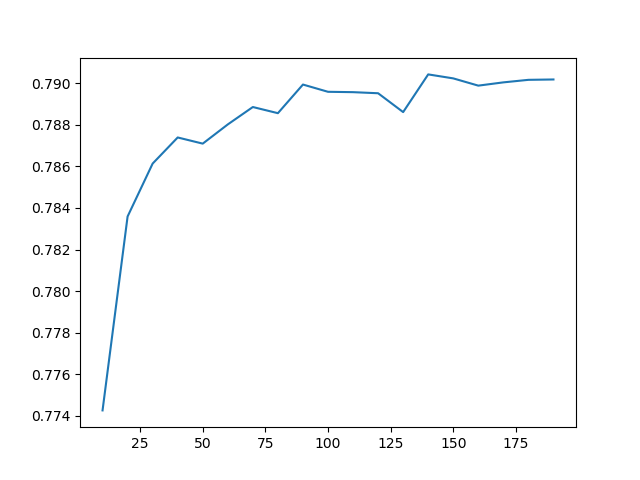

In [605]:
plt.figure()
plt.plot(range(10,200,10),scores_rf)

In [604]:
scores_knn=[]
for i in range(10,200,10):
    scores_knn.append(eval_model_1(KNeighborsClassifier(n_neighbors=i)))

In [612]:
print(max(scores_knn))
print(scores_knn.index(max(scores_knn))*10)

0.789329518293
100


In [617]:
eval_model_1(KNeighborsClassifier(n_neighbors=100,weights='distance'))

0.78934696512378522

In [618]:
eval_model_1(KNeighborsClassifier(n_neighbors=100,weights='distance',p=1))

0.78856185773854182

<IPython.core.display.Javascript object>


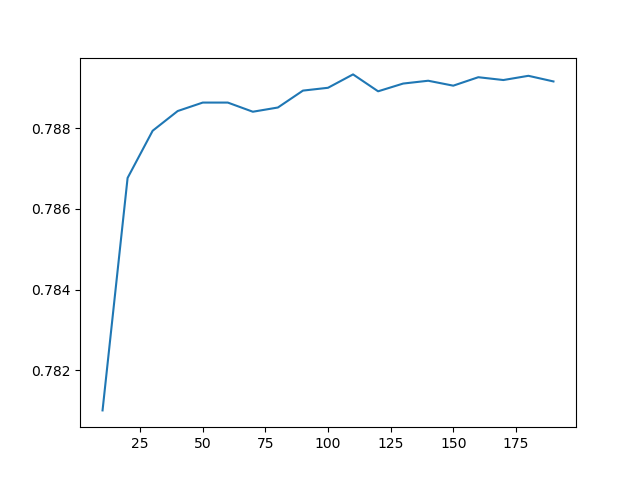

In [611]:
plt.figure()
plt.plot(range(10,200,10),scores_knn)

# It seems there is very minor improvement in ensembling of beauty products. Let's check for other groups . It might work well with fashion for ex

In [665]:
df_fashion_val=pd.read_csv('fashion_val_proba_nlp.csv')

In [666]:
accuracy_score(df_fashion_val.pred,df_fashion_val.Category)

0.6496665983933001

In [667]:
df_im_fashion=pd.read_csv('val_fashion.csv')

In [668]:
accuracy_score(df_im_fashion.final_pred,df_im_fashion.Category)

0.49061241209804057

In [669]:
df_im_fashion['correct_pred']=(df_im_fashion.final_pred==df_im_fashion['Category'])

In [670]:
df_im_fashion.groupby('Category').correct_pred.mean()

Category
17    0.009042
18    0.774273
19    0.228603
20    0.391892
21    0.021936
22    0.052545
23    0.485030
24    0.017647
25    0.719192
26    0.585168
27    0.247840
28    0.360277
29    0.167665
30    0.000000
Name: correct_pred, dtype: float64

In [671]:
df_im_fashion['image_path2']=df_im_fashion['index']

In [672]:
test_fashion=test[test.Group=='fashion'].copy()

In [675]:
test_fashion['image_path2']=test_fashion['image_path'].map(lambda x: x[14:]+'.jpg')
test_fashion.head()

,itemid,title,Category,image_path,Group,image_path2
473036,286463264,blus sexy model off shoulder,26,fashion_image/cb790137111e2525cd895c3375fe84c0,fashion,cb790137111e2525cd895c3375fe84c0.jpg
355772,1465709373,dress midi bodycon casual elegan warna polos u...,22,fashion_image/cbedaa2404fb377dc6c271a1081f7baa,fashion,cbedaa2404fb377dc6c271a1081f7baa.jpg
486345,129360583,kemeja hitam wanita katun adem lengan pendek b...,27,fashion_image/7a4194bf7b509f29bfc5dcd9cc0355d9,fashion,7a4194bf7b509f29bfc5dcd9cc0355d9.jpg
347206,1756097750,gaun midi bodycon wanita dengan model lengan p...,22,fashion_image/a15e616c290fb142b1a8b217951f765c,fashion,a15e616c290fb142b1a8b217951f765c.jpg
294868,1188784503,no.1 family blus sabrina sexy lengan panjang t...,22,fashion_image/c343ed06853c285d85996d5302ccf90e,fashion,c343ed06853c285d85996d5302ccf90e.jpg


In [676]:
test_fashion=test_fashion.merge(df_im_fashion,on='image_path2',how='outer')

In [678]:
test_fashion.columns

Index(['itemid', 'title', 'Category_x', 'image_path', 'Group', 'image_path2',
       'index', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
       '27', '28', '29', '30', 'final_pred', 'Category_y', 'correct_pred'],
      dtype='object')

In [626]:
df_fashion_val['correct_pred']=(df_fashion_val['Category']==df_fashion_val['pred'])

In [627]:
df_fashion_val.groupby('Category').correct_pred.mean()

Category
17    0.180832
18    0.778691
19    0.584290
20    0.548799
21    0.303767
22    0.423645
23    0.688623
24    0.248235
25    0.785525
26    0.740434
27    0.590432
28    0.591224
29    0.645210
30    0.145833
Name: correct_pred, dtype: float64

In [679]:
df_all_fashion=df_fashion_val[[str(i) for i in range(17,31)]].copy()

In [681]:
df_all_fashion.columns=['nlp_'+str(i) for i in range(17,31)]

In [691]:
df_all_fashion=df_all_fashion.join(test_fashion[[str(i) for i in range(17,31)]])

In [699]:
def eval_model_fashion(model):
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_fashion_val))
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_fashion,df_fashion_val.Category)):
        print("Fold:",fold_)
        X_train=df_all_fashion.loc[trn_idx,:]
        y_train=df_fashion_val.Category[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_fashion.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
        print('Acuracy of fold:',accuracy_score(df_fashion_val.Category[val_idx],oof[val_idx]))
    return accuracy_score(df_fashion_val.Category,oof)

In [700]:
# Wow! This one is much better!
eval_model_fashion(LogisticRegression())

Fold: 0
Acuracy of fold: 0.665718835305
Fold: 1
Acuracy of fold: 0.66010692754
Fold: 2
Acuracy of fold: 0.659613196815
Fold: 3
Acuracy of fold: 0.657220894503
Fold: 4
Acuracy of fold: 0.651975856964


0.65892901845656671

In [701]:
eval_model_fashion(SVC())

Fold: 0
Acuracy of fold: 0.666628753412
Fold: 1
Acuracy of fold: 0.657490615402
Fold: 2
Acuracy of fold: 0.653469852105
Fold: 3
Acuracy of fold: 0.656993285535
Fold: 4
Acuracy of fold: 0.651634210227


0.65724494208142736

In [702]:
def eval_model_fashion_1(model):
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_fashion_val))
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_fashion,df_fashion_val.Category)):
#         print("Fold:",fold_)
        X_train=df_all_fashion.loc[trn_idx,:]
        y_train=df_fashion_val.Category[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_fashion.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
#         print('Acuracy of fold:',accuracy_score(df_fashion_val.Category[val_idx],oof[val_idx]))
    return accuracy_score(df_fashion_val.Category,oof)

In [703]:
scores_fashion_rf=[]
for i in range(10,200,10):
    scores_fashion_rf.append(eval_model_fashion_1(RandomForestClassifier(n_estimators=i)))


In [708]:
print(max(scores_fashion_rf),scores_fashion_rf.index(max(scores_fashion_rf))*10)


0.660635852621 150


In [704]:
scores_fashion_knn=[]
for i in range(10,200,10):
    scores_fashion_knn.append(eval_model_fashion_1(KNeighborsClassifier(n_neighbors=i)))

In [706]:
max(scores_fashion_knn)

0.65836007373523586

In [710]:
import lightgbm as lgb
import xgboost as xgb

In [822]:
param={'objective':'multiclass','num_class':14}

In [823]:
y=df_fashion_val.Category

In [824]:
y=y-17

In [825]:
y.unique().shape

(14,)

In [826]:
train_lgb=lgb.Dataset(df_all_fashion,label=y)

In [830]:
lgb_cv=lgb.cv(param,train_lgb,num_boost_round=200,nfold=5,verbose_eval=10)

[10]	cv_agg's multi_logloss: 1.35503 + 0.00659562
[20]	cv_agg's multi_logloss: 1.16682 + 0.0085313
[30]	cv_agg's multi_logloss: 1.0982 + 0.00893922
[40]	cv_agg's multi_logloss: 1.07036 + 0.00941579
[50]	cv_agg's multi_logloss: 1.05807 + 0.00924386
[60]	cv_agg's multi_logloss: 1.05268 + 0.00884932
[70]	cv_agg's multi_logloss: 1.05096 + 0.00860336
[80]	cv_agg's multi_logloss: 1.05111 + 0.00844791
[90]	cv_agg's multi_logloss: 1.05225 + 0.00841554
[100]	cv_agg's multi_logloss: 1.05403 + 0.00807444
[110]	cv_agg's multi_logloss: 1.05608 + 0.0082148
[120]	cv_agg's multi_logloss: 1.05846 + 0.00829303
[130]	cv_agg's multi_logloss: 1.06118 + 0.0085883
[140]	cv_agg's multi_logloss: 1.06402 + 0.00876636
[150]	cv_agg's multi_logloss: 1.06672 + 0.0090267
[160]	cv_agg's multi_logloss: 1.06961 + 0.00922768
[170]	cv_agg's multi_logloss: 1.07246 + 0.00949845
[180]	cv_agg's multi_logloss: 1.07553 + 0.00970616
[190]	cv_agg's multi_logloss: 1.07831 + 0.00996194
[200]	cv_agg's multi_logloss: 1.08163 + 0.010

In [863]:
def check_lgb():
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros((len(df_fashion_val),14))
    param={'objective':'ovr','num_class':14,'tree_learner':'voting' }
    y=df_fashion_val.Category-17
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_fashion,y)):
        print("Fold:",fold_)
        train_=lgb.Dataset(df_all_fashion.loc[trn_idx,:],y[trn_idx])
        val_=lgb.Dataset(df_all_fashion.loc[val_idx,:],y[val_idx])
        clf=lgb.train(param,train_,200,valid_sets=[train_,val_])
        oof[val_idx]=clf.predict(df_all_fashion.loc[val_idx,:],clf.best_iteration)
#         print('Acuracy of fold:',accuracy_score(df_fashion_val.Category[val_idx],oof[val_idx]))
    return oof
    

In [864]:
pred_lgb=check_lgb()

Fold: 0
[1]	training's multi_logloss: 1.73619	valid_1's multi_logloss: 1.77346
[2]	training's multi_logloss: 1.57693	valid_1's multi_logloss: 1.62712
[3]	training's multi_logloss: 1.46092	valid_1's multi_logloss: 1.52323
[4]	training's multi_logloss: 1.37175	valid_1's multi_logloss: 1.44319
[5]	training's multi_logloss: 1.30078	valid_1's multi_logloss: 1.38164
[6]	training's multi_logloss: 1.24242	valid_1's multi_logloss: 1.33222
[7]	training's multi_logloss: 1.193	valid_1's multi_logloss: 1.2907
[8]	training's multi_logloss: 1.15065	valid_1's multi_logloss: 1.25648
[9]	training's multi_logloss: 1.11471	valid_1's multi_logloss: 1.22733
[10]	training's multi_logloss: 1.08246	valid_1's multi_logloss: 1.20226
[11]	training's multi_logloss: 1.0541	valid_1's multi_logloss: 1.18145
[12]	training's multi_logloss: 1.02859	valid_1's multi_logloss: 1.1631
[13]	training's multi_logloss: 1.0056	valid_1's multi_logloss: 1.14757
[14]	training's multi_logloss: 0.984641	valid_1's multi_logloss: 1.1341

[113]	training's multi_logloss: 0.525508	valid_1's multi_logloss: 1.12493
[114]	training's multi_logloss: 0.523567	valid_1's multi_logloss: 1.12584
[115]	training's multi_logloss: 0.521687	valid_1's multi_logloss: 1.1269
[116]	training's multi_logloss: 0.519435	valid_1's multi_logloss: 1.1276
[117]	training's multi_logloss: 0.517352	valid_1's multi_logloss: 1.12835
[118]	training's multi_logloss: 0.515453	valid_1's multi_logloss: 1.12908
[119]	training's multi_logloss: 0.5132	valid_1's multi_logloss: 1.13032
[120]	training's multi_logloss: 0.510859	valid_1's multi_logloss: 1.13157
[121]	training's multi_logloss: 0.508556	valid_1's multi_logloss: 1.13228
[122]	training's multi_logloss: 0.506575	valid_1's multi_logloss: 1.13318
[123]	training's multi_logloss: 0.504584	valid_1's multi_logloss: 1.13449
[124]	training's multi_logloss: 0.502318	valid_1's multi_logloss: 1.13566
[125]	training's multi_logloss: 0.500269	valid_1's multi_logloss: 1.13707
[126]	training's multi_logloss: 0.498024	v

[24]	training's multi_logloss: 0.852393	valid_1's multi_logloss: 1.07792
[25]	training's multi_logloss: 0.84248	valid_1's multi_logloss: 1.07541
[26]	training's multi_logloss: 0.834042	valid_1's multi_logloss: 1.07305
[27]	training's multi_logloss: 0.825668	valid_1's multi_logloss: 1.07143
[28]	training's multi_logloss: 0.817739	valid_1's multi_logloss: 1.07019
[29]	training's multi_logloss: 0.810069	valid_1's multi_logloss: 1.06917
[30]	training's multi_logloss: 0.802146	valid_1's multi_logloss: 1.06858
[31]	training's multi_logloss: 0.795404	valid_1's multi_logloss: 1.06828
[32]	training's multi_logloss: 0.789409	valid_1's multi_logloss: 1.06765
[33]	training's multi_logloss: 0.783572	valid_1's multi_logloss: 1.06739
[34]	training's multi_logloss: 0.777981	valid_1's multi_logloss: 1.06745
[35]	training's multi_logloss: 0.772027	valid_1's multi_logloss: 1.06762
[36]	training's multi_logloss: 0.766176	valid_1's multi_logloss: 1.06786
[37]	training's multi_logloss: 0.760856	valid_1's mu

[136]	training's multi_logloss: 0.477167	valid_1's multi_logloss: 1.15599
[137]	training's multi_logloss: 0.47543	valid_1's multi_logloss: 1.15738
[138]	training's multi_logloss: 0.4737	valid_1's multi_logloss: 1.15848
[139]	training's multi_logloss: 0.472026	valid_1's multi_logloss: 1.15955
[140]	training's multi_logloss: 0.470328	valid_1's multi_logloss: 1.16028
[141]	training's multi_logloss: 0.468548	valid_1's multi_logloss: 1.16146
[142]	training's multi_logloss: 0.466996	valid_1's multi_logloss: 1.16247
[143]	training's multi_logloss: 0.465315	valid_1's multi_logloss: 1.16347
[144]	training's multi_logloss: 0.463619	valid_1's multi_logloss: 1.16432
[145]	training's multi_logloss: 0.46174	valid_1's multi_logloss: 1.16501
[146]	training's multi_logloss: 0.459907	valid_1's multi_logloss: 1.16622
[147]	training's multi_logloss: 0.458129	valid_1's multi_logloss: 1.16702
[148]	training's multi_logloss: 0.456267	valid_1's multi_logloss: 1.16758
[149]	training's multi_logloss: 0.454514	v

[47]	training's multi_logloss: 0.71178	valid_1's multi_logloss: 1.10291
[48]	training's multi_logloss: 0.707629	valid_1's multi_logloss: 1.10359
[49]	training's multi_logloss: 0.703438	valid_1's multi_logloss: 1.10483
[50]	training's multi_logloss: 0.699192	valid_1's multi_logloss: 1.10587
[51]	training's multi_logloss: 0.695321	valid_1's multi_logloss: 1.10654
[52]	training's multi_logloss: 0.691376	valid_1's multi_logloss: 1.10761
[53]	training's multi_logloss: 0.687618	valid_1's multi_logloss: 1.10847
[54]	training's multi_logloss: 0.683581	valid_1's multi_logloss: 1.10939
[55]	training's multi_logloss: 0.680108	valid_1's multi_logloss: 1.11024
[56]	training's multi_logloss: 0.676551	valid_1's multi_logloss: 1.11094
[57]	training's multi_logloss: 0.673342	valid_1's multi_logloss: 1.11157
[58]	training's multi_logloss: 0.669873	valid_1's multi_logloss: 1.11228
[59]	training's multi_logloss: 0.665838	valid_1's multi_logloss: 1.11329
[60]	training's multi_logloss: 0.662182	valid_1's mu

[158]	training's multi_logloss: 0.458813	valid_1's multi_logloss: 1.24384
[159]	training's multi_logloss: 0.455184	valid_1's multi_logloss: 1.245
[160]	training's multi_logloss: 0.453424	valid_1's multi_logloss: 1.24618
[161]	training's multi_logloss: 0.451874	valid_1's multi_logloss: 1.24739
[162]	training's multi_logloss: 0.444598	valid_1's multi_logloss: 1.24528
[163]	training's multi_logloss: 0.452621	valid_1's multi_logloss: 1.25153
[164]	training's multi_logloss: 0.451072	valid_1's multi_logloss: 1.25145
[165]	training's multi_logloss: 0.449446	valid_1's multi_logloss: 1.25249
[166]	training's multi_logloss: 0.446796	valid_1's multi_logloss: 1.24705
[167]	training's multi_logloss: 0.445535	valid_1's multi_logloss: 1.24835
[168]	training's multi_logloss: 0.448833	valid_1's multi_logloss: 1.25451
[169]	training's multi_logloss: 0.444652	valid_1's multi_logloss: 1.25192
[170]	training's multi_logloss: 0.441623	valid_1's multi_logloss: 1.25298
[171]	training's multi_logloss: 0.443004

[70]	training's multi_logloss: 0.629823	valid_1's multi_logloss: 1.09991
[71]	training's multi_logloss: 0.627099	valid_1's multi_logloss: 1.10074
[72]	training's multi_logloss: 0.624141	valid_1's multi_logloss: 1.10175
[73]	training's multi_logloss: 0.621543	valid_1's multi_logloss: 1.10287
[74]	training's multi_logloss: 0.61853	valid_1's multi_logloss: 1.10351
[75]	training's multi_logloss: 0.615885	valid_1's multi_logloss: 1.10428
[76]	training's multi_logloss: 0.613094	valid_1's multi_logloss: 1.10539
[77]	training's multi_logloss: 0.610358	valid_1's multi_logloss: 1.10702
[78]	training's multi_logloss: 0.607532	valid_1's multi_logloss: 1.10779
[79]	training's multi_logloss: 0.604895	valid_1's multi_logloss: 1.10879
[80]	training's multi_logloss: 0.602335	valid_1's multi_logloss: 1.10981
[81]	training's multi_logloss: 0.599593	valid_1's multi_logloss: 1.11054
[82]	training's multi_logloss: 0.596997	valid_1's multi_logloss: 1.11163
[83]	training's multi_logloss: 0.594569	valid_1's mu

[181]	training's multi_logloss: 0.409418	valid_1's multi_logloss: 1.20931
[182]	training's multi_logloss: 0.40811	valid_1's multi_logloss: 1.21013
[183]	training's multi_logloss: 0.406674	valid_1's multi_logloss: 1.21112
[184]	training's multi_logloss: 0.405194	valid_1's multi_logloss: 1.21238
[185]	training's multi_logloss: 0.40393	valid_1's multi_logloss: 1.21331
[186]	training's multi_logloss: 0.402458	valid_1's multi_logloss: 1.21442
[187]	training's multi_logloss: 0.400859	valid_1's multi_logloss: 1.21526
[188]	training's multi_logloss: 0.399531	valid_1's multi_logloss: 1.21614
[189]	training's multi_logloss: 0.398332	valid_1's multi_logloss: 1.21689
[190]	training's multi_logloss: 0.39685	valid_1's multi_logloss: 1.21772
[191]	training's multi_logloss: 0.395491	valid_1's multi_logloss: 1.21892
[192]	training's multi_logloss: 0.394076	valid_1's multi_logloss: 1.21992
[193]	training's multi_logloss: 0.392773	valid_1's multi_logloss: 1.22081
[194]	training's multi_logloss: 0.391425	

[93]	training's multi_logloss: 0.565168	valid_1's multi_logloss: 1.15002
[94]	training's multi_logloss: 0.562641	valid_1's multi_logloss: 1.15116
[95]	training's multi_logloss: 0.560253	valid_1's multi_logloss: 1.1519
[96]	training's multi_logloss: 0.558019	valid_1's multi_logloss: 1.15237
[97]	training's multi_logloss: 0.555601	valid_1's multi_logloss: 1.15378
[98]	training's multi_logloss: 0.553265	valid_1's multi_logloss: 1.15473
[99]	training's multi_logloss: 0.551064	valid_1's multi_logloss: 1.15544
[100]	training's multi_logloss: 0.549017	valid_1's multi_logloss: 1.15673
[101]	training's multi_logloss: 0.546555	valid_1's multi_logloss: 1.15789
[102]	training's multi_logloss: 0.544103	valid_1's multi_logloss: 1.15916
[103]	training's multi_logloss: 0.541976	valid_1's multi_logloss: 1.16003
[104]	training's multi_logloss: 0.539778	valid_1's multi_logloss: 1.16087
[105]	training's multi_logloss: 0.537488	valid_1's multi_logloss: 1.16177
[106]	training's multi_logloss: 0.535198	valid

In [865]:
pred_lgb_max=pred_lgb.argmax(axis=1)

In [866]:
pred_lgb_max+17

array([26, 22, 27, ..., 26, 25, 25], dtype=int64)

In [867]:
accuracy_score(df_fashion_val.Category.values,pred_lgb_max+17)

0.65612981042761886

# Seems like for both Beauty and Fashion best ensemble is with random forrest classifier. Let's get ensembling results for both of them. Today, I want to submit first results . Let's also combined files used for ensembling.
## How are we going to predict for test? Is it going to based on voting or combining probabilities...
#


In [874]:
df_test.groupby('Group').count()

,itemid,title,image_path
Group,,,
beauty_,76545,76545,76545
fashion,55440,55440,55440
mobile_,40417,40417,40417


## for now let's ensemble mobile

In [877]:
df_im_mobile=pd.read_csv('val_mobile.csv')
accuracy_score(df_im_mobile.Category,df_im_mobile.final_pred)

0.56276313737720252

In [878]:
df_nlp_mobile=pd.read_csv('mobile__val_proba_nlp.csv')

In [879]:
accuracy_score(df_nlp_mobile.Category,df_nlp_mobile.pred)

0.82819273351005773

In [881]:
test_mobile=test[test.Group=='mobile_']

In [882]:
test_mobile['image_path2']=test_mobile['image_path'].map(lambda x: x[13:])

In [885]:
df_im_mobile['image_path2']=df_im_mobile['index']

In [887]:
test_mobile=test_mobile.merge(df_im_mobile,on='image_path2',how='outer')

In [890]:
df_nlp_mobile.columns

Index(['31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42',
       '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', 'pred', 'itemid', 'Category'],
      dtype='object')

In [891]:
df_all_mobile=df_nlp_mobile[[str(31) for i in range(31,58)]].copy()

In [892]:
df_all_mobile.columns=['nlp_'+str(31) for i in range(31,58)]

In [895]:
df_all_mobile=df_all_mobile.join(test_mobile[[str(i) for i in range(31,58)]])

In [897]:
df_all_mobile.head()

,nlp_31,nlp_31,nlp_31,nlp_31,nlp_31,nlp_31,nlp_31,nlp_31,nlp_31,nlp_31,...,48,49,50,51,52,53,54,55,56,57
0,0.005766,0.005766,0.005766,0.005766,0.005766,0.005766,0.005766,0.005766,0.005766,0.005766,...,0.000356,0.003329,0.005001,0.000660,0.001180,0.000943,0.000728,0.000967,0.000833,0.000563
1,0.001909,0.001909,0.001909,0.001909,0.001909,0.001909,0.001909,0.001909,0.001909,0.001909,...,0.001899,0.011421,0.000813,0.000252,0.000367,0.000301,0.000122,0.001252,0.000214,0.000445
2,0.008517,0.008517,0.008517,0.008517,0.008517,0.008517,0.008517,0.008517,0.008517,0.008517,...,0.000342,0.001120,0.000136,0.002763,0.001903,0.000443,0.007212,0.000416,0.000406,0.000569
3,0.002786,0.002786,0.002786,0.002786,0.002786,0.002786,0.002786,0.002786,0.002786,0.002786,...,0.001046,0.000533,0.000309,0.000054,0.000225,0.000511,0.000033,0.000112,0.000249,0.000087
4,0.973635,0.973635,0.973635,0.973635,0.973635,0.973635,0.973635,0.973635,0.973635,0.973635,...,0.000294,0.000040,0.000005,0.000052,0.000018,0.000056,0.000236,0.000021,0.000038,0.000015


In [899]:
df_nlp_mobile.columns

Index(['31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42',
       '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', 'pred', 'itemid', 'Category'],
      dtype='object')

In [904]:
def eval_model_mobile(model):
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_nlp_mobile))
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_mobile,df_nlp_mobile.Category)):
        print("Fold:",fold_)
        X_train=df_all_mobile.loc[trn_idx,:]
        y_train=df_nlp_mobile.Category[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_mobile.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
        print('Acuracy of fold:',accuracy_score(df_nlp_mobile.Category[val_idx],oof[val_idx]))
    return accuracy_score(df_nlp_mobile.Category,oof)

In [905]:
eval_model_mobile(LogisticRegression())

Fold: 0
Acuracy of fold: 0.598100280287
Fold: 1
Acuracy of fold: 0.606981455509
Fold: 2
Acuracy of fold: 0.609603991269
Fold: 3
Acuracy of fold: 0.590703478397
Fold: 4
Acuracy of fold: 0.606780190595


0.60243255886480584

In [906]:
eval_model_mobile(SVC())

Fold: 0
Acuracy of fold: 0.575054500156
Fold: 1
Acuracy of fold: 0.575970079476
Fold: 2
Acuracy of fold: 0.580137199875
Fold: 3
Acuracy of fold: 0.566058337233
Fold: 4
Acuracy of fold: 0.584283705671


0.57629814439419924

In [914]:
eval_model_mobile(MultinomialNB())

Fold: 0
Acuracy of fold: 0.526004360012
Fold: 1
Acuracy of fold: 0.523297491039
Fold: 2
Acuracy of fold: 0.526972248207
Fold: 3
Acuracy of fold: 0.51458430822
Fold: 4
Acuracy of fold: 0.536009998438


0.52537034149384065

In [907]:
def eval_model_mobile_1(model):
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_nlp_mobile))
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_mobile,df_nlp_mobile.Category)):
#         print("Fold:",fold_)
        X_train=df_all_mobile.loc[trn_idx,:]
        y_train=df_nlp_mobile.Category[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_mobile.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
#         print('Acuracy of fold:',accuracy_score(df_nlp_mobile.Category[val_idx],oof[val_idx]))
    return accuracy_score(df_nlp_mobile.Category,oof)

In [908]:
scores_mobile_rf=[]
for i in range(10,200,10):
    scores_fashion_rf.append(eval_model_mobile_1(RandomForestClassifier(n_estimators=i)))

In [912]:
print(max(scores_fashion_rf))

0.660635852621


In [909]:
scores_mobile_knn=[]
for i in range(10,200,10):
    scores_mobile_knn.append(eval_model_mobile_1(KNeighborsClassifier(n_neighbors=i)))

In [913]:
max(scores_mobile_knn)

0.61309839388741616

# It seems that ensembling mobile makes it worser. Probably , because it gives similar weigth for the features. Let's keep mobile predictions, and do modifications for beauty and fashion.

In [920]:
df_all_beauty=df_all_prob.copy()
df_all_beauty.shape

(57317, 34)

In [918]:
df_all_fashion.shape

(43941, 28)

### Let's upload probabilities of test. Remember that we have two prediction one is trained for 80% of data and another with 100% of data.
### Up to now we optimize our for validation set. But we don't have validation set for 100% of data
### I am also not sure for to combine predictions for test set. should I combine probabilities or should I do voting on 5 of them 

In [1188]:
y_all_fashion=test[test.Group=='fashion'].Category
y_all_beauty=test[test.Group=='beauty'].Category

In [1349]:
# Let's get test probabilities for both fashion and beauty
df_test_beauty_im=pd.read_csv('test_beauty.csv')
df_test_beauty_nlp=pd.read_csv('beauty__test_proba_nlp.csv')
df_test_fashion_im=pd.read_csv('test_fashion.csv')
df_test_fashion_nlp=pd.read_csv('fashion_test_proba_nlp.csv')
# I don't have probabilities trained to all data! 
# I need them as well
# Here is it . u can find details in nlp_pipeline-saving test pred probs.ipynb
df_test_beauty_nlp_all=pd.read_csv('beauty__test_proba_nlp_all_data.csv')
df_test_fashion_nlp_all=pd.read_csv('fashion_test_proba_nlp_all_data.csv')

In [1350]:
test_beauty_all=df_test[df_test.Group=='beauty_'].copy()
test_fashion_all=df_test[df_test.Group=='fashion'].copy()


In [1351]:
test_beauty_all['image_path']=test_beauty_all['image_path'].map(lambda x : x[13:])
test_fashion_all['image_path']=test_fashion_all['image_path'].map(lambda x : x[14:])

In [1352]:
col_names=['nlp_'+str(i) for i in range(17)]
col_names.append('pred')
col_names.append('itemid')
df_test_beauty_nlp.columns=col_names
df_test_beauty_nlp_all.columns=col_names

In [1353]:
test_beauty_all1=test_beauty_all.merge(df_test_beauty_nlp,on='itemid')
test_beauty_all2=test_beauty_all.merge(df_test_beauty_nlp_all,on='itemid')

del test_beauty_all1['pred']
del test_beauty_all2['pred']

In [1354]:
test_beauty_all1=test_beauty_all1.merge(df_test_beauty_im, on='image_path')
test_beauty_all2=test_beauty_all2.merge(df_test_beauty_im, on='image_path')

del test_beauty_all1['pred']
del test_beauty_all2['pred']


In [1355]:
test_beauty_all1.columns

Index(['itemid', 'title', 'image_path', 'Group', 'nlp_0', 'nlp_1', 'nlp_2',
       'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9', 'nlp_10',
       'nlp_11', 'nlp_12', 'nlp_13', 'nlp_14', 'nlp_15', 'nlp_16', '0', '1',
       '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7',
       '8', '9'],
      dtype='object')

In [1356]:
col1=['nlp_'+str(i) for i in range(17)]

In [1357]:
col2=[str(i) for i in range(17)]

In [1358]:
col3=col1+col2

In [1359]:
# X_test for beauty is ready
X_test_beauty1=test_beauty_all1[col3]
X_test_beauty2=test_beauty_all2[col3]

In [1225]:
df_test_fashion_nlp.columns

Index(['17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '30', 'pred', 'itemid'],
      dtype='object')

In [1360]:
col_names=['nlp_'+str(i) for i in range(17,31)]
col_names.append('pred')
col_names.append('itemid')
df_test_fashion_nlp.columns=col_names
df_test_fashion_nlp_all.columns=col_names

In [1361]:
test_fashion_all1=test_fashion_all.merge(df_test_fashion_nlp,on='itemid')
test_fashion_all2=test_fashion_all.merge(df_test_fashion_nlp_all,on='itemid')

del test_fashion_all1['pred']
del test_fashion_all2['pred']

In [1362]:
test_fashion_all1=test_fashion_all1.merge(df_test_fashion_im, on='image_path')
test_fashion_all2=test_fashion_all2.merge(df_test_fashion_im, on='image_path')

del test_fashion_all1['pred']
del test_fashion_all2['pred']

In [1363]:
# Test predictions for fashion
X_test_fashion1=test_fashion_all1.iloc[:,4:]
X_test_fashion2=test_fashion_all2.iloc[:,4:]


In [1378]:
X_test_fashion2.shape

(55440, 28)

In [1379]:
# For both of them random forrest gived best results . These are validations sets used as training sets
df_all_beauty.shape,df_all_fashion.shape

((57317, 34), (43941, 28))

In [1239]:
y_all_beauty=test[test.Group=='beauty_'].Category.values
y_all_fashion=test[test.Group=='fashion'].Category.values

In [1240]:
accuracy_score(y_all_beauty,df_beauty_val.Category.values)

1.0

In [1241]:
accuracy_score(y_all_beauty,df_beauty_val.pred.values)

0.78843972992305944

In [1242]:
df_all_beauty.iloc[:,17:].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.002413,0.644621,0.000998,0.082524,0.185229,0.039663,0.000129,0.005326,0.000772,0.033910,0.001621,0.000406,0.000633,0.000953,0.000371,0.000054,0.000377
1,0.004281,0.045959,0.013224,0.722170,0.023957,0.147752,0.002059,0.003475,0.006804,0.015817,0.000369,0.001236,0.010823,0.000401,0.000729,0.000254,0.000692
2,0.001220,0.056316,0.289336,0.124023,0.015513,0.488652,0.000476,0.002027,0.011963,0.007191,0.000071,0.002718,0.000313,0.000019,0.000111,0.000012,0.000040
3,0.004866,0.039073,0.000995,0.028858,0.313440,0.549227,0.000116,0.004704,0.000787,0.048756,0.000594,0.000344,0.005737,0.000891,0.000419,0.000092,0.001101
4,0.000828,0.009464,0.000383,0.001625,0.033192,0.036198,0.000008,0.001147,0.000120,0.915869,0.000020,0.000047,0.000512,0.000203,0.000226,0.000021,0.000138


In [1165]:
# Smth wrong with this function
# def eval_model(model,X,y, X_test):
#     folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
#     oof=np.zeros(len(X))
#     predictions=np.zeros((len(X_test),folds.n_splits))
#     for fold_,(trn_idx,val_idx) in enumerate(folds.split(X,y)):
#         print("Fold:",fold_)
#         X_train=X.loc[trn_idx,:]
#         y_train=y[trn_idx]
#         model.fit(X,y)
#         X_val=X.loc[val_idx,:]
#         y_val=y[val_idx]
#         oof[val_idx]=model.predict(X_val)
#         predictions[:,fold_]=model.predict(X_test)
#         print('Acuracy of fold:',accuracy_score(y_val,oof[val_idx]))
#     print('Overall accuracy:',accuracy_score(y,oof))
#     return predictions

In [1251]:
# Previous function to evaluate model for beauty products
def eval_model(model):
    y=df_beauty_val.Category
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_all_prob))
    # prediction for the model with 80 of data
    pred_80=np.zeros((len(X_test_beauty1),folds.n_splits))
    #prediction for the model with 100 of data
    pred_100=np.zeros((len(X_test_beauty2),folds.n_splits))

    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_prob,y)):
        print("Fold:",fold_)
        X_train=df_all_prob.loc[trn_idx,:]
        y_train=y[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_prob.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
        pred_80[:,fold_]=model.predict(X_test_beauty1)
        pred_100[:,fold_]=model.predict(X_test_beauty2)
        print('Acuracy of fold:',accuracy_score(y[val_idx],oof[val_idx]))
    print('Acuracy of overall:',accuracy_score(y,oof))
    return pred_80,pred_100,


In [1263]:
# Previous function to evaluate model for beauty products
def eval_model_tr(model):
    y=df_beauty_val.Category
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_all_prob))
    # prediction for the model with 80 of data
#     pred_80=np.zeros((len(X_test_beauty1),folds.n_splits))
    #prediction for the model with 100 of data
#     pred_100=np.zeros((len(X_test_beauty2),folds.n_splits))

    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_prob,y)):
#         print("Fold:",fold_)
        X_train=df_all_prob.loc[trn_idx,:]
        y_train=y[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_prob.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
#         pred_80[:,fold_]=model.predict(X_test_beauty1)
#         pred_100[:,fold_]=model.predict(X_test_beauty2)
#         print('Acuracy of fold:',accuracy_score(y[val_idx],oof[val_idx]))
    print('Acuracy of overall:',accuracy_score(y,oof))
    return accuracy_score(y,oof)


In [699]:
def eval_model_fashion(model):
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_fashion_val))
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_fashion,df_fashion_val.Category)):
        print("Fold:",fold_)
        X_train=df_all_fashion.loc[trn_idx,:]
        y_train=df_fashion_val.Category[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_fashion.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
        print('Acuracy of fold:',accuracy_score(df_fashion_val.Category[val_idx],oof[val_idx]))
    return accuracy_score(df_fashion_val.Category,oof)

In [1265]:
scores=[]
for i in range(10,200,10):
    scores.append(eval_model_tr(RandomForestClassifier(n_estimators=i)))

Acuracy of overall: 0.774325243819
Acuracy of overall: 0.783903553919
Acuracy of overall: 0.786346110229
Acuracy of overall: 0.787672069369
Acuracy of overall: 0.788439729923
Acuracy of overall: 0.788963134847
Acuracy of overall: 0.788544410908
Acuracy of overall: 0.78903292217
Acuracy of overall: 0.789573773924
Acuracy of overall: 0.789085262662
Acuracy of overall: 0.789067815831
Acuracy of overall: 0.789643561247
Acuracy of overall: 0.789155049985
Acuracy of overall: 0.790725264756
Acuracy of overall: 0.789434199278
Acuracy of overall: 0.789765689063
Acuracy of overall: 0.790079732017
Acuracy of overall: 0.789434199278
Acuracy of overall: 0.789957604201


In [1286]:
max(scores),scores.index(max(scores))*10+10

(0.79072526475565719, 140)

In [1289]:
pred80,pred100=eval_model(RandomForestClassifier(n_estimators=140))

Fold: 0
Acuracy of fold: 0.785963382738
Fold: 1
Acuracy of fold: 0.788050588748
Fold: 2
Acuracy of fold: 0.797347989183
Fold: 3
Acuracy of fold: 0.792619089164
Fold: 4
Acuracy of fold: 0.787466177883
Acuracy of overall: 0.790289093986


In [1292]:
df_sub_beauty=pd.DataFrame(pred100).mode(axis=1)

In [1296]:
# This will be used for submission
df_sub_beauty=df_sub_beauty[0].astype('int')

array([ 5,  5,  5, ..., 13, 12, 14])

In [1275]:
# I wonder about neural networks maybe it can give better results. Let's try simple 
from sklearn.neural_network import MLPClassifier
nn=MLPClassifier(hidden_layer_sizes=(28,))

In [1276]:
eval_model_tr(nn)

Acuracy of overall: 0.789277177801


0.78927717780065254

In [1280]:
nn=MLPClassifier(hidden_layer_sizes=(28,14))
eval_model_tr(nn)

Acuracy of overall: 0.789189943647


0.78918994364673656

In [1278]:
nn1=MLPClassifier(hidden_layer_sizes=(28,),activation='logistic')
eval_model_tr(nn1)

Acuracy of overall: 0.789678454909


0.78967845490866584

In [1279]:
nn2=MLPClassifier(hidden_layer_sizes=(28,),activation='tanh')
eval_model_tr(nn2)

Acuracy of overall: 0.789521433432


0.78952143343161718

In [1271]:
pred_nn=nn.predict(df_all_prob)

In [1273]:
accuracy_score(df_beauty_val.Category,pred_nn)

0.79185930875656441

In [1386]:
X_test_fashion1.shape[0],X_test_fashion2.shape[0]

(55440, 55440)

In [1388]:
# Let's work with fashion predictions now
def eval_model_fashion(model):
    folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)
    oof=np.zeros(len(df_fashion_val))
    #prediction for 80% of data
    pred_80=np.zeros((len(X_test_fashion1),folds.n_splits))
    #prediction for the model with 100 of data
    pred_100=np.zeros((len(X_test_fashion2),folds.n_splits))
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(df_all_fashion,df_fashion_val.Category)):
        print("Fold:",fold_)
        X_train=df_all_fashion.loc[trn_idx,:]
        y_train=df_fashion_val.Category[trn_idx]
        model.fit(X_train,y_train)
        X_val=df_all_fashion.loc[val_idx,:]
        oof[val_idx]=model.predict(X_val)
        pred_80[:,fold_]=model.predict(X_test_fashion1)
        pred_100[:,fold_]=model.predict(X_test_fashion2)
        print('Acuracy of fold:',accuracy_score(df_fashion_val.Category[val_idx],oof[val_idx]))
    print('Acuracy of overall:',accuracy_score(df_fashion_val.Category,oof))
    return pred_80,pred_100

In [1399]:
pred80,pred100=eval_model_fashion(RandomForestClassifier(n_estimators=150))

Fold: 0
Acuracy of fold: 0.665491355778
Fold: 1
Acuracy of fold: 0.662723239677
Fold: 2
Acuracy of fold: 0.659044368601
Fold: 3
Acuracy of fold: 0.658700352794
Fold: 4
Acuracy of fold: 0.65368409065
Acuracy of overall: 0.659930361166


In [1400]:
pred100.shape

(55440, 5)

In [1401]:
df_sub_fashion=pd.DataFrame(pred100)

In [1402]:
df_sub_fashion=df_sub_fashion.mode(axis=1)[0]

In [1403]:
# Let' change beauty and fashion for our best submission which was trained by nlp for 100 data
df_sub=pd.read_csv("2_nlp_all_data.csv")

In [1404]:
df1=df_test[df_test.Group=='beauty_']
df2=df_test[df_test.Group=='fashion']

In [1405]:
df2.shape,df_sub_fashion.shape

((55440, 4), (55440,))

In [1406]:
df_sub.loc[:76544,'Category'].shape

(76545,)

In [1413]:
df_sub_beauty.values

array([ 5,  5,  5, ..., 13, 12, 14])

In [1414]:
df1['Category']=df_sub_beauty.values

In [1415]:
# Let's check the difference btw submissions!
accuracy_score(df_sub.loc[:76544,'Category'],df1.Category)

0.93018485857992028

In [1416]:
df_sub1=df_sub.copy()
df_sub1.loc[:76544,'Category']=df1.Category

In [1422]:
df_sub_fashion=df_sub_fashion.astype('int')

In [1423]:
df2['Category']=df_sub_fashion.values

In [1427]:
# How much is fashion submission is different from previous submission
accuracy_score(df_sub1.loc[df2.index,'Category'],df2['Category'])

0.92682178932178927

In [1428]:
df_sub1.loc[df2.index,'Category']=df2['Category']

In [1429]:
# How much it is different from previous submission overall
accuracy_score(df_sub.Category,df_sub1.Category)

0.94547047018016028

In [1430]:
# LB: 0.763518
# Extremely smoll improvement

df_sub1.to_csv('2nlp_ensembled_with_im.csv',index=False)

In [1432]:
# Let's try to use improvement on fashion results.
df_sub2=df_sub.copy()

In [1433]:
# LB:0.0.76322
df_sub2.loc[df2.index,'Category']=df2['Category']
df_sub2.to_csv('2nlp_ensembled_with_im_only_fashion.csv',index=False)

In [1080]:
predictions_lr=eval_model(LogisticRegression(),df_all_beauty,y_all_beauty,X_test_beauty)

Fold: 0
Acuracy of fold: 0.786835222319
Fold: 1
Acuracy of fold: 0.78578281727
Fold: 2
Acuracy of fold: 0.794556398848
Fold: 3
Acuracy of fold: 0.793840516489
Fold: 4
Acuracy of fold: 0.787204329231
Overall accuracy: 0.789643561247


In [1111]:
predictions=eval_model(RandomForestClassifier(n_estimators=20),df_all_beauty,y_all_beauty,X_test_beauty)

Fold: 0
Acuracy of fold: 0.995640802092
Fold: 1
Acuracy of fold: 0.996075010903
Fold: 2
Acuracy of fold: 0.995201954113
Fold: 3
Acuracy of fold: 0.994154597801
Fold: 4
Acuracy of fold: 0.993802915248
Overall accuracy: 0.994975312734


In [1169]:
# Smth is really wrong. I need write code again. Probably missing smth. 
predictions_fashion=eval_model(RandomForestClassifier(n_estimators=120),df_all_fashion,y_all_fashion,X_test_fashion)

Fold: 0
Acuracy of fold: 1.0
Fold: 1
Acuracy of fold: 1.0
Fold: 2
Acuracy of fold: 1.0
Fold: 3
Acuracy of fold: 1.0
Fold: 4
Acuracy of fold: 1.0
Overall accuracy: 1.0


In [1170]:
predictions_fashion=eval_model(LogisticRegression(),df_all_fashion,y_all_fashion,X_test_fashion)

Fold: 0
Acuracy of fold: 0.666515013649
Fold: 1
Acuracy of fold: 0.660334432943
Fold: 2
Acuracy of fold: 0.659158134243
Fold: 3
Acuracy of fold: 0.658245134858
Fold: 4
Acuracy of fold: 0.651520327981
Overall accuracy: 0.659156596345


In [1068]:
df=pd.DataFrame(predictions)

In [1077]:
# Save 130 results
df_beauty_accuracy_1=pd.DataFrame(predictions)

In [1136]:
df_sub=pd.read_csv('first_nlp_submission.csv')

In [1144]:
df_sub.head()

,itemid,Category
0,370855998,5
1,637234604,5
2,690282890,5
3,930913462,4
4,1039280071,5


In [1137]:
df_sub_beauty=df_test[df_test.Group=='beauty_']

In [1139]:
df_sub_beauty.head()

,itemid,title,image_path,Group
0,370855998,flormar 7 white cream bb spf 30 40ml,beauty_image/1588591395c5a254bab84042005f2a9f.jpg,beauty_
1,637234604,maybelline clear smooth all in one bb cream sp...,beauty_image/920985ed9587ea20f58686ea74e20f93.jpg,beauty_
2,690282890,murah innisfree eco natural green tea bb cream...,beauty_image/90b40e5710f54352b243fcfb0f5d1d7f.jpg,beauty_
3,930913462,loreal white perfect day cream spf 17 pa white...,beauty_image/289c668ef3d70e1d929d602d52d5d78a.jpg,beauty_
4,1039280071,hada labo cc cream ultimate anti aging spf 35 ...,beauty_image/d5b3e652c5822d2306f4560488ec30c6.jpg,beauty_


In [1140]:
df_sub_beauty['Category']=df_beauty_accuracy_1[4].astype('int')

In [1142]:
df_sub_beauty=df_sub_beauty[['itemid','Category']]

In [1149]:
df_sub.shape,df_sub_beauty.shape

((172402, 2), (76545, 2))

In [1150]:
df_sub_beauty.set_index('itemid',inplace=True)

In [1152]:
df_sub.set_index('itemid',inplace=True)

In [1158]:
df_sub.loc[df_sub_beauty.index,'Category']=df_sub_beauty.Category

In [1160]:
df_sub.reset_index(inplace=True)

In [1162]:
df_sub.to_csv('ensemble_1st_sub.csv',index=False)

In [543]:
lr=LogisticRegression()
svc=SVC()
nb=MultinomialNB()
knn=KNeighborsClassifier()
pipe_ensemble=Pipeline(['model',lr])
param_en={'model':[lr,svc,nb,knn]}
grid_search=GridSearchCV(pipe_ensemble,param_grid=param,cv=5)
grid_search.fit(df_all_prob,y)

TypeError: zip argument #2 must support iteration

In [370]:
bc_beauty=BaggingClassifier(base_estimator=LogisticRegression(),n_estimators=10)
X=train[train.Group=='beauty_'].title
cv=CountVectorizer(stop_words=ignore_words,ngram_range=(1,5))
X=cv.fit_transform(X)
y=train[train.Group=='beauty_'].Category.values
bc_beauty.fit(X,y)
X_test=test[test.Group=='beauty_'].title
X_test=cv.transform(X_test)
bc_beauty.score(X_test,test[test.Group=='beauty_'].Category.values)

0.78486312961250593

In [386]:
# Single model
df=pd.read_csv('beauty__val_proba_nlp.csv')
accuracy_score(df.Category,df.pred)

0.78843972992305944

In [402]:
# Validation from image regocnition
df_im=pd.read_csv('val_beauty.csv')
accuracy_score(df_im.Category,df_im.final_pred)

0.6406476263586719

In [403]:
df_im['pred_true']=(df_im['Category']==df_im['final_pred'])

In [404]:
df_im.groupby('Category').pred_true.mean()

Category
0     0.232095
1     0.448204
2     0.663058
3     0.869169
4     0.610330
5     0.628889
6     0.034230
7     0.519280
8     0.366116
9     0.166564
10    0.246512
11    0.229927
12    0.874885
13    0.248322
14    0.010969
15    0.050000
16    0.008969
Name: pred_true, dtype: float64

In [405]:
df.groupby('Category').pred_true.mean()

Category
0     0.464191
1     0.659574
2     0.876137
3     0.903631
4     0.769033
5     0.804450
6     0.481663
7     0.757926
8     0.644628
9     0.571252
10    0.669767
11    0.624088
12    0.899679
13    0.583893
14    0.283364
15    0.208333
16    0.260090
Name: pred_true, dtype: float64

In [392]:
df['pred_true']=(df['Category']==df['pred'])

<IPython.core.display.Javascript object>


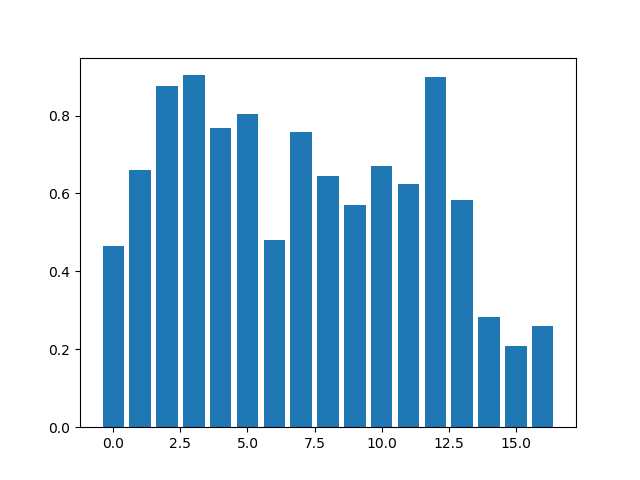

<Container object of 17 artists>

In [400]:
plt.figure()
plt.bar(height=df.groupby('Category').pred_true.mean().values,x=df.groupby('Category').pred_true.mean().index)

In [389]:
# Let's try Adaboost
bc_beauty=AdaBoostClassifier(base_estimator=LogisticRegression(),n_estimators=100)
X=train[train.Group=='beauty_'].title
cv=CountVectorizer(stop_words=ignore_words,ngram_range=(1,5))
X=cv.fit_transform(X)
y=train[train.Group=='beauty_'].Category.values
bc_beauty.fit(X,y)
X_test=test[test.Group=='beauty_'].title
X_test=cv.transform(X_test)
bc_beauty.score(X_test,test[test.Group=='beauty_'].Category.values)

0.64891742414990317

In [406]:
from sklearn.ensemble import VotingClassifier,RandomForestClassifier

In [407]:
groups

['beauty_', 'mobile_', 'fashion']

In [410]:
svc

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [427]:
cv=CountVectorizer(stop_words =ignore_words)

In [428]:
X=train[train.Group=='beauty_'].title

In [429]:
X=cv.fit_transform(X)

In [435]:
svc

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [433]:

pipe_beauty=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,min_df=5)),('model',svc)])
pipe_mobile=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,min_df=5)),('model',svc)])
pipe_fashion=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,min_df=5)),('model',svc)])
pipe_svc=[pipe_beauty,pipe_mobile,pipe_fashion]

accuracy={}
for i in tqdm(range(len(groups))):
    X=train[train.Group==groups[i]].title
    y=train[train.Group==groups[i]].Category
    model=pipe_svc[i]
    model.fit(X,y)
    X_test=test[test.Group==groups[i]].title
    y_test=test[test.Group==groups[i]].Category
    y_pred=model.predict(X_test)
    accuracy[group[i]]=accuracy_score(y_test,y_pred)
    print(groups[i]+ ' accuracy score :',accuracy_score(y_test,y_pred))











  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

beauty_ accuracy score : 0.752377130694










 33%|██████████████████████████▋                                                     | 1/3 [47:04<1:34:09, 2824.65s/it]

mobile_ accuracy score : 0.793513176361










 67%|█████████████████████████████████████████████████████▎                          | 2/3 [1:02:49<37:40, 2260.74s/it]

fashion accuracy score : 0.590655651897










100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [2:10:46<00:00, 2805.59s/it]

In [434]:
# Logistic regression seems to be better than svm... Maybe parameter tunning is required
pipe_beauty_lr=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,min_df=5)),('model',lr)])
pipe_mobile_lr=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,min_df=5)),('model',lr)])
pipe_fashion_lr=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words,min_df=5)),('model',lr)])
pipe_lr=[pipe_beauty_lr,pipe_mobile_lr,pipe_fashion_lr]

accuracy_lr={}
for i in tqdm(range(len(groups))):
    X=train[train.Group==groups[i]].title
    y=train[train.Group==groups[i]].Category
    model=pipe_lr[i]
    model.fit(X,y)
    X_test=test[test.Group==groups[i]].title
    y_test=test[test.Group==groups[i]].Category
    y_pred=model.predict(X_test)
    accuracy_lr[group[i]]=accuracy_score(y_test,y_pred)
    print(groups[i]+ ' accuracy score :',accuracy_score(y_test,y_pred))









  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

beauty_ accuracy score : 0.761030758763










 33%|████████████████████████████                                                        | 1/3 [01:14<02:29, 74.93s/it]

mobile_ accuracy score : 0.809854982068










 67%|████████████████████████████████████████████████████████                            | 2/3 [01:56<01:04, 64.91s/it]

fashion accuracy score : 0.603900685009










100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:09<00:00, 67.44s/it]

In [437]:
accuracy_score(df_beauty_val.Category,df_beauty_val.pred)

0.78843972992305944

In [439]:
accuracy_score(df_image_beauty.Category,df_image_beauty.final_pred)

0.6406476263586719

In [443]:
df_image_beauty.head()


,index,0,1,10,11,12,13,14,15,16,2,3,4,5,6,7,8,9,final_pred,Category
0,0057fd944e705684de3b169f1fd7b20e.jpg,0.000922,0.063919,0.000129,0.002412,0.036417,0.015067,0.011914,0.000337,0.017487,0.075449,0.579613,0.063179,0.118592,0.000373,0.002519,0.002103,0.009568,3,0
1,0093bb60e9adb6b2d842d87d4a8d6130.jpg,0.016552,0.028079,0.000746,0.091571,0.003485,0.000700,0.000629,0.000639,0.000780,0.275765,0.210556,0.026311,0.011866,0.011437,0.027535,0.285640,0.007712,8,0
2,00e358a25a00c6edabbff0f7c4fa424e.jpg,0.001821,0.001831,0.000504,0.000466,0.764857,0.050797,0.099181,0.008131,0.030099,0.001431,0.007295,0.022690,0.001862,0.000222,0.004479,0.000819,0.003514,12,0
3,0123b0a5ebbd601a14357274ebcdde46.jpg,0.019760,0.051505,0.002228,0.005470,0.037858,0.023969,0.008131,0.001418,0.019008,0.006417,0.043640,0.609103,0.086127,0.002845,0.019252,0.018621,0.044650,4,0
4,01ec05eb7e3f009b254ccc116d21ed3c.jpg,0.171279,0.184560,0.000596,0.099867,0.001841,0.000397,0.000278,0.000162,0.000261,0.060845,0.159701,0.058774,0.020588,0.052695,0.024520,0.146287,0.017349,1,0


In [446]:
test_beauty=test[test.Group=='beauty_']

In [448]:
test_beauty['image_path2']=test_beauty['image_path'].map(lambda x: x[13:])

In [450]:
df_image_beauty['image_path2']=df_image_beauty['index']

In [454]:
df_image_beauty.set_index('image_path2',inplace=True)

In [455]:
test_beauty['image_pred']=test_beauty['image_path2'].map(df_image_beauty['final_pred'])

In [459]:
print(accuracy_score(test_beauty['Category'],test_beauty['image_pred']))

0.640647626359


In [463]:
# Extremely low correlation! But wait does it take as category or just numbers... 
# Probably we need to check it by having onehot encoding
df_beauty_val.pred.corr(test_beauty['image_pred'])

0.014599649414768044

In [464]:
from sklearn.preprocessing import OneHotEncoder

In [465]:
nlp=OneHotEncoder(df_beauty_val.pred)

In [468]:
image=OneHotEncoder(test_beauty['image_pred'])

In [469]:
nlp.corr(image)

AttributeError: 'OneHotEncoder' object has no attribute 'corr'

In [375]:
# Let's check accuracy in validation set
for group in predictions_val.keys():
    test_=test.copy()
    test_.loc[test_.Group==group,'Category']=predictions_val[group]
print(accuracy_score(test.Category,test_.Category))
# Wow results seems to be impressive 0.884536051544

ValueError: Must have equal len keys and value when setting with an ndarray

In [381]:
accuracy_score(test[test.Group=='beauty_'].Category,predictions_val['beauty_'])


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [314]:
# run it at night
# let's use svc with 'linear' kernel
svc=SVC(C=0.1,kernel='linear')
pipe_models=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words)),('model',svc)])
params={'model':[svc,nb,lr]}
best_param_models={}
best_score_models={}
for group in tqdm(['beauty_','mobile_','fashion']):
    grid_search=GridSearchCV(pipe_models,param_grid=params, verbose=1)
    X=df_train[df_train.Group==group].title
    y=df_train[df_train.Group==group].Category
    grid_search.fit(X,y)
    best_param_models[group]=grid_search.best_params_
    print(group+ ' best parameters :',grid_search.best_params_ )
    best_score_models[group]=grid_search.best_score_
    print(group+ ' best score :',grid_search.best_score_)







  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [295]:
accuracy_score(df.idxmax(axis=1),df_nlp.Category)

0.78826526161522759

In [ ]:
# Another simple thing to try is to ensemble with NB approach
df_all_val=pd.DataFrame()
for i in range(3):
    df=test[test.Group==groups[i]].copy()
    
df_beauty=test[test]



In [97]:
pipe[2].classes_

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)

In [74]:
len(predictions_test['beauty_'])+len(predictions_test['mobile_'])+len(predictions_test['fashion'])

172402

In [75]:
df_sub=df_test.copy()
for group in predictions.keys():
    df_sub.loc[df_sub.Group==group,'Category']=predictions_test[group]

In [81]:
df_sub.Category.astype('int')

0          5
1          5
2          5
3          4
4          5
5          3
6          4
7          5
8          5
9          5
10         5
11         2
12         3
13         4
14         5
15         5
16         3
17         9
18         5
19         3
20         3
21         3
22         5
23         5
24         3
25         5
26         3
27         5
28         4
29         5
          ..
172372    41
172373    41
172374    38
172375    48
172376    35
172377    31
172378    44
172379    40
172380    35
172381    35
172382    35
172383    31
172384    31
172385    32
172386    35
172387    43
172388    34
172389    43
172390    31
172391    42
172392    32
172393    41
172394    42
172395    42
172396    35
172397    38
172398    31
172399    35
172400    35
172401    34
Name: Category, Length: 172402, dtype: int32

In [ ]:
# testing n jobs
pipe_lr=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words)),('model',lr)])
params={'model':[svc,lr,nb]}
best_param={}
best_score={}
for group in tqdm(['beauty_','mobile_','fashion']):
    grid_search=GridSearchCV(pipe_lr,param_grid=params, verbose=1)
    X=df_train[df_train.Group==group].title
    y=df_train[df_train.Group==group].Category
    grid_search.fit(X,y)
    best_param[group]=grid_search.best_params_
    best_score[group]=grid_search.best_score_

In [ ]:
print(best_param)
print(best_score)

In [ ]:
pipe_svc=Pipeline([('vectorize', CountVectorizer(stop_words =ignore_words)),('model',scv)])
pipe_csv.fit(df_train[df_train.Group==group])




In [24]:
grid_search.best_score_

0.78257607743655411

In [25]:
grid_search.best_score_

0.78257607743655411

In [28]:
grid_search.best_params_

{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

In [23]:
results['beauty_'].best_score_

0.72668650966735637

In [50]:
df_train['Group']=df_train.image_path.map(lambda x: x[:7])
df_train.head()


,itemid,title,Category,image_path,Group
0,307504,nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg,beauty_
1,461203,etude house precious mineral any cushion pearl...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9.jpg,beauty_
2,3592295,milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9.jpg,beauty_
3,4460167,etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da.jpg,beauty_
4,5853995,bedak revlon color stay aqua mineral make up,3,beauty_image/9c6968066ebab57588c2f757a240d8b9.jpg,beauty_


In [51]:
trn_idx=train.index
val_idx=test.index

In [60]:
params={'vectorize__ngram_range':[(1,1),(1,2)],'model':[nb,lr,svc]}
grid_search=GridSearchCV(pipe_lr,param_grid=params)

In [62]:
%%time
grid_search.fit(df_train[df_train.Group=='beauty_'].title,df_train[df_train.Group=='beauty_'].Category)

Wall time: 32.1 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorize', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'yakn...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorize__ngram_range': [(1, 1), (1, 2)], 'model': [MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [64]:
from tqdm import tqdm

In [ ]:
params={'vectorize__ngram_range':[(1,1),(1,2)],'model':[nb,lr,svc]}
grid_search=GridSearchCV(pipe_lr,param_grid=params)
results={}
for group in tqdm(['beauty_','mobile_','fashion']):
    X=train[train.Group==group].title
    y=train[train.Group==group].Category
    grid_search.fit(X,y)
    results[group]=grid_search

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

In [71]:
type(grid_search)


sklearn.model_selection._search.GridSearchCV

In [ ]:
trn_idx=train.index
tst_idx=test.index

In [ ]:
results={}
for group in ['beauty_','mobile_','fashion']:
    X=train[train.Group==group].title
    y=train[train.Group==group].Category
    grid_search.fit(X,y)
    results[group]=grid_search

In [65]:
grid_search


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorize', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorize__ngram_range': [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)], 'model': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)]},
       pre_dispatch='2*n_jobs', 